### Assignment A.3: Using LLMs for Entity Extraction
#### Author - Rashmi Patel

### Introduction
<p> Entity extraction, also known as Named Entity Recognition (NER), is the task of identifying and classifying key information (entities) in text into predefined categories such as people, organizations, locations, dates, quantities, etc. Large Language Models (LLMs) like BERT, GPT, and T5 are well-suited for this task due to their ability to understand context and meaning in large text corpora.</p>

### Checking POS Tags Distribution 

#### POS Tags Distribution with BERT and spacy


Analyzing documents...


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]



Analysis Summary:
Total tokens analyzed: 1349
Unique tokens: 572
Number of entities found: 86

Top words by POS tag:

NOUN:
  movie: 10
  minutes: 4
  wins: 4
  characters: 4
  relationship: 4

NUM:
  two: 3
  150: 2
  four: 2
  one: 2
  million: 2

PROPN:
  Best: 6
  Picture: 5
  Beautiful: 4
  Mind: 4
  Review: 3

PUNCT:
  ,: 67
  .: 46
  -: 4
  !: 2
  ?: 2

ADJ:
  great: 4
  such: 4
  good: 3
  first: 3
  Last: 2

ADP:
  of: 27
  in: 13
  for: 10
  with: 6
  like: 5

DET:
  the: 63
  a: 26
  The: 13
  A: 6
  this: 5

VERB:
  know: 4
  make: 3
  understand: 3
  felt: 3
  have: 3

PRON:
  I: 22
  it: 12
  they: 8
  its: 5
  that: 5

AUX:
  is: 14
  be: 10
  was: 8
  do: 6
  were: 6

PART:
  to: 18
  not: 10
  nt: 9
  To: 1

ADV:
  even: 4
  also: 4
  literally: 4
  just: 4
  so: 4

SCONJ:
  that: 12
  if: 4
  how: 4
  while: 3
  like: 2

CCONJ:
  and: 40
  but: 4
  or: 2

INTJ:
  like: 4
  Heck: 1


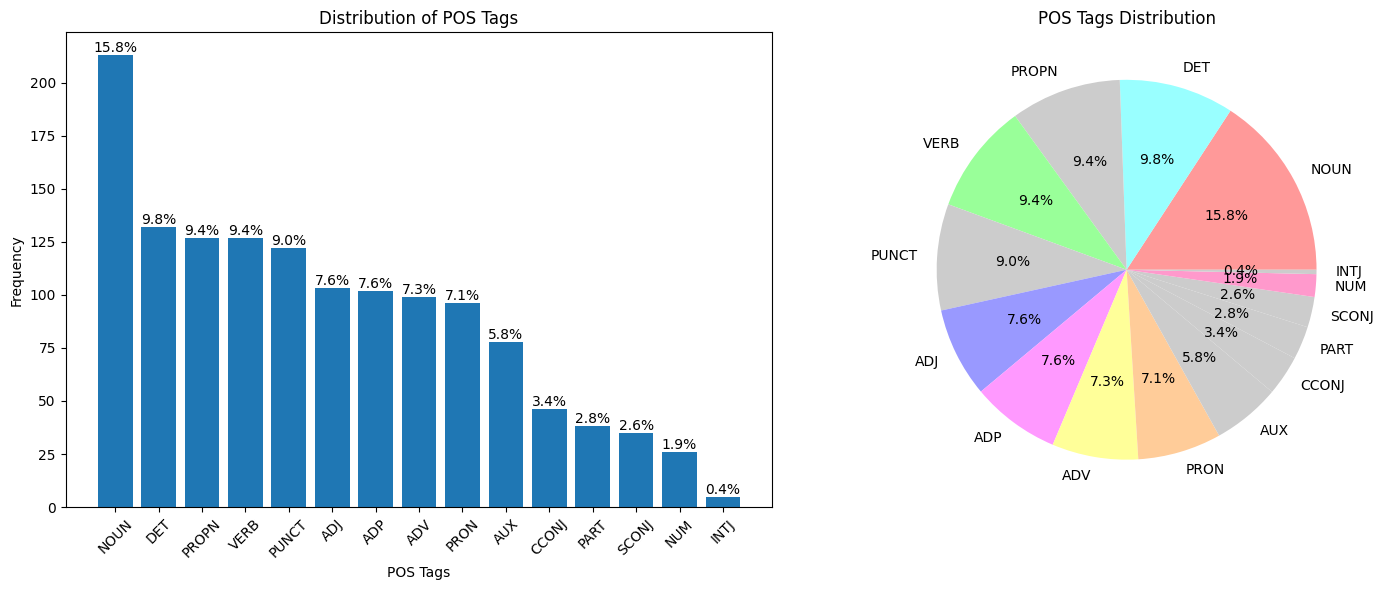

In [209]:
# Import necessary libraries
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from docx import Document
from tqdm import tqdm
import warnings
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Suppress warnings
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

# Constants
SPACY_MODEL = "en_core_web_sm"
BERT_MODEL = "dbmdz/bert-large-cased-finetuned-conll03-english"
MAX_LENGTH = 512
POS_COLORS = {
    'NOUN': '#ff9999', 'VERB': '#99ff99', 'ADJ': '#9999ff',
    'ADV': '#ffff99', 'ADP': '#ff99ff', 'DET': '#99ffff',
    'PRON': '#ffcc99', 'CONJ': '#99ccff', 'NUM': '#ff99cc'
}

class MovieReviewAnalyzer:
    def __init__(self):
        # Initialize spaCy
        self.nlp = spacy.load(SPACY_MODEL)
        
        # Initialize BERT
        self.tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
        self.model = AutoModelForTokenClassification.from_pretrained(BERT_MODEL)
        self.model.eval()

    def read_docx(self, file_path: str) -> Optional[str]:
        """Read and extract text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text: str) -> str:
        """Clean and normalize text while preserving important features."""
        if not text:
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,!?-]', '', text)
        return text.strip()

    def analyze_text(self, text: str) -> List[Dict]:
        """Perform detailed POS analysis on text."""
        doc = self.nlp(text)
        return [{
            'text': token.text,
            'lemma': token.lemma_,
            'pos': token.pos_,
            'tag': token.tag_,
            'dep': token.dep_,
            'is_stop': token.is_stop,
            'is_punct': token.is_punct,
            'is_space': token.is_space,
            'shape': token.shape_,
            'is_alpha': token.is_alpha,
            'is_digit': token.is_digit
        } for token in doc]

    def extract_entities(self, text: str) -> List[Tuple[str, str]]:
        """Extract entities using BERT."""
        inputs = self.tokenizer(text, return_tensors="pt", 
                              truncation=True,
                              max_length=MAX_LENGTH,
                              padding=True)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["[CLS]", "[SEP]", "[PAD]"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                if token.startswith("##"):
                    if current_entity:
                        current_entity.append(token[2:])
                else:
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                    current_entity = [token]
                    current_label = label
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append(("".join(current_entity), current_label))
        
        return entities

    def create_visualizations(self, pos_stats: Dict):
        """Create and display POS visualizations."""
        # POS Distribution
        plt.figure(figsize=(15, 6))
        pos_items = sorted(pos_stats['pos_distribution'].items(), key=lambda x: x[1], reverse=True)
        pos_tags, frequencies = zip(*pos_items)
        
        # Bar plot
        plt.subplot(1, 2, 1)
        bars = plt.bar(pos_tags, frequencies)
        plt.title('Distribution of POS Tags', fontsize=12)
        plt.xlabel('POS Tags')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        
        # Add percentage labels
        total = sum(frequencies)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{(height/total)*100:.1f}%',
                    ha='center', va='bottom')
        
        # Pie chart
        plt.subplot(1, 2, 2)
        plt.pie(frequencies, labels=pos_tags, autopct='%1.1f%%',
                colors=[POS_COLORS.get(tag, '#cccccc') for tag in pos_tags])
        plt.title('POS Tags Distribution', fontsize=12)
        
        plt.tight_layout()
        plt.show()

    def analyze_folder(self, folder_path: str):
        """Analyze all documents in the specified folder."""
        all_pos_data = []
        all_entities = []
        
        print("\nAnalyzing documents...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx(file_path)
                
                if text:
                    text = self.clean_text(text)
                    
                    # POS Analysis
                    pos_data = self.analyze_text(text)
                    all_pos_data.extend(pos_data)
                    
                    # Entity Extraction
                    chunks = [text[i:i+MAX_LENGTH] for i in range(0, len(text), MAX_LENGTH)]
                    for chunk in chunks:
                        entities = self.extract_entities(chunk)
                        all_entities.extend(entities)
        
        # Create DataFrame and calculate statistics
        pos_df = pd.DataFrame(all_pos_data)
        pos_stats = {
            'total_tokens': len(pos_df),
            'unique_tokens': pos_df['text'].nunique(),
            'pos_distribution': pos_df['pos'].value_counts().to_dict(),
            'dependency_distribution': pos_df['dep'].value_counts().to_dict(),
            'top_words_by_pos': {pos: pos_df[pos_df['pos'] == pos]['text'].value_counts().head(5).to_dict()
                                for pos in pos_df['pos'].unique()}
        }
        
        return pos_df, pos_stats, all_entities

def main():
    # Initialize analyzer
    analyzer = MovieReviewAnalyzer()
    
    # Set folder path
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'
    
    # Run analysis
    pos_df, pos_stats, entities = analyzer.analyze_folder(folder_path)
    
    # Print summary statistics
    print("\nAnalysis Summary:")
    print(f"Total tokens analyzed: {pos_stats['total_tokens']}")
    print(f"Unique tokens: {pos_stats['unique_tokens']}")
    print(f"Number of entities found: {len(entities)}")
    
    # Display top words for each POS tag
    print("\nTop words by POS tag:")
    for pos, words in pos_stats['top_words_by_pos'].items():
        print(f"\n{pos}:")
        for word, count in words.items():
            print(f"  {word}: {count}")
    
    # Create visualizations
    analyzer.create_visualizations(pos_stats)
    
    return pos_df, pos_stats, entities

if __name__ == "__main__":
    pos_df, pos_stats, entities = main()

### POS Tags Distribution with RoBERTa and spacy


Analyzing documents...


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



Analysis Summary:
Total tokens analyzed: 1349
Unique tokens: 572
Number of entities found: 1203

Top words by POS tag:

NOUN:
  movie: 10
  minutes: 4
  wins: 4
  characters: 4
  relationship: 4

NUM:
  two: 3
  150: 2
  four: 2
  one: 2
  million: 2

PROPN:
  Best: 6
  Picture: 5
  Beautiful: 4
  Mind: 4
  Review: 3

PUNCT:
  ,: 67
  .: 46
  -: 4
  !: 2
  ?: 2

ADJ:
  great: 4
  such: 4
  good: 3
  first: 3
  Last: 2

ADP:
  of: 27
  in: 13
  for: 10
  with: 6
  like: 5

DET:
  the: 63
  a: 26
  The: 13
  A: 6
  this: 5

VERB:
  know: 4
  make: 3
  understand: 3
  felt: 3
  have: 3

PRON:
  I: 22
  it: 12
  they: 8
  its: 5
  that: 5

AUX:
  is: 14
  be: 10
  was: 8
  do: 6
  were: 6

PART:
  to: 18
  not: 10
  nt: 9
  To: 1

ADV:
  even: 4
  also: 4
  literally: 4
  just: 4
  so: 4

SCONJ:
  that: 12
  if: 4
  how: 4
  while: 3
  like: 2

CCONJ:
  and: 40
  but: 4
  or: 2

INTJ:
  like: 4
  Heck: 1


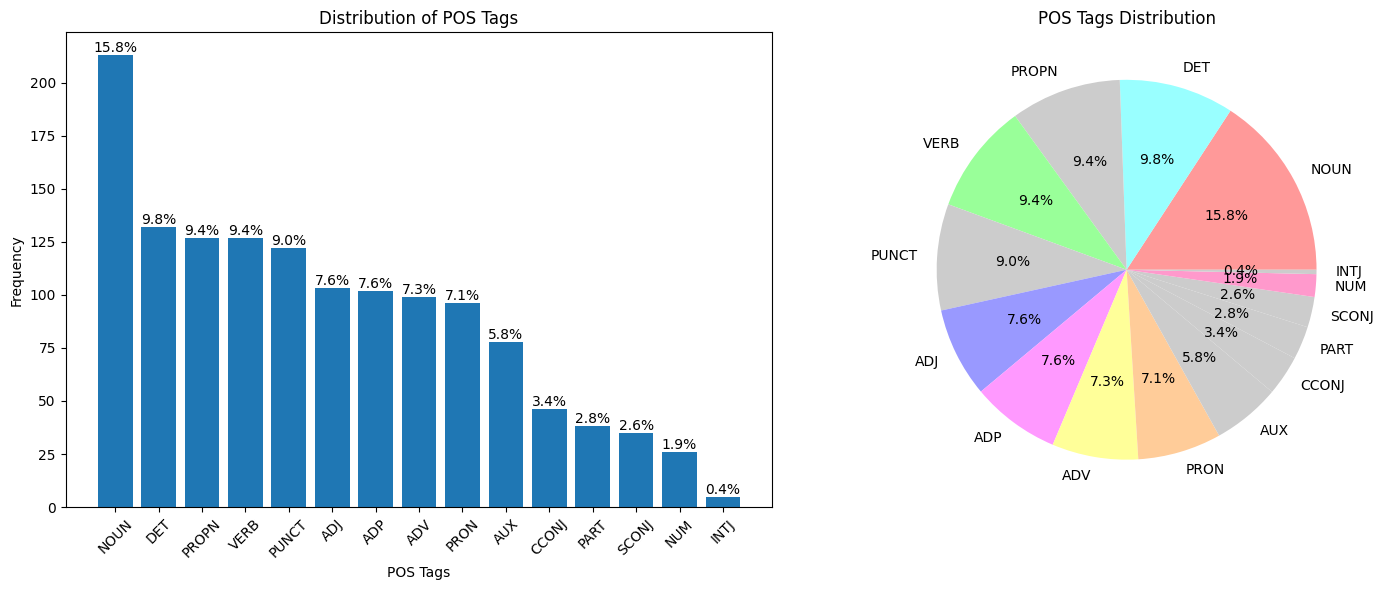

In [137]:
# Import necessary libraries
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from docx import Document
from tqdm import tqdm
import warnings
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Suppress warnings
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

# Constants
SPACY_MODEL = "en_core_web_sm"
ROBERTA_MODEL = "roberta-base"  # Replace with a fine-tuned RoBERTa model for NER if available
MAX_LENGTH = 512
POS_COLORS = {
    'NOUN': '#ff9999', 'VERB': '#99ff99', 'ADJ': '#9999ff',
    'ADV': '#ffff99', 'ADP': '#ff99ff', 'DET': '#99ffff',
    'PRON': '#ffcc99', 'CONJ': '#99ccff', 'NUM': '#ff99cc'
}

class MovieReviewAnalyzer:
    def __init__(self):
        # Initialize spaCy
        self.nlp = spacy.load(SPACY_MODEL)
        
        # Initialize RoBERTa
        self.tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
        self.model = AutoModelForTokenClassification.from_pretrained(ROBERTA_MODEL)
        self.model.eval()

    def read_docx(self, file_path: str) -> Optional[str]:
        """Read and extract text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text: str) -> str:
        """Clean and normalize text while preserving important features."""
        if not text:
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,!?-]', '', text)
        return text.strip()

    def analyze_text(self, text: str) -> List[Dict]:
        """Perform detailed POS analysis on text."""
        doc = self.nlp(text)
        return [{
            'text': token.text,
            'lemma': token.lemma_,
            'pos': token.pos_,
            'tag': token.tag_,
            'dep': token.dep_,
            'is_stop': token.is_stop,
            'is_punct': token.is_punct,
            'is_space': token.is_space,
            'shape': token.shape_,
            'is_alpha': token.is_alpha,
            'is_digit': token.is_digit
        } for token in doc]

    def extract_entities(self, text: str) -> List[Tuple[str, str]]:
        """Extract entities using RoBERTa."""
        inputs = self.tokenizer(text, return_tensors="pt", 
                                truncation=True,
                                max_length=MAX_LENGTH,
                                padding=True)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["<s>", "</s>", "<pad>"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                if token.startswith("Ġ"):  # Handling subword tokens in RoBERTa
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                    current_entity = [token.lstrip("Ġ")]
                    current_label = label
                else:
                    if current_entity:
                        current_entity.append(token)
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append(("".join(current_entity), current_label))
        
        return entities

    def create_visualizations(self, pos_stats: Dict):
        """Create and display POS visualizations."""
        # POS Distribution
        plt.figure(figsize=(15, 6))
        pos_items = sorted(pos_stats['pos_distribution'].items(), key=lambda x: x[1], reverse=True)
        pos_tags, frequencies = zip(*pos_items)
        
        # Bar plot
        plt.subplot(1, 2, 1)
        bars = plt.bar(pos_tags, frequencies)
        plt.title('Distribution of POS Tags', fontsize=12)
        plt.xlabel('POS Tags')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        
        # Add percentage labels
        total = sum(frequencies)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{(height/total)*100:.1f}%',
                    ha='center', va='bottom')
        
        # Pie chart
        plt.subplot(1, 2, 2)
        plt.pie(frequencies, labels=pos_tags, autopct='%1.1f%%',
                colors=[POS_COLORS.get(tag, '#cccccc') for tag in pos_tags])
        plt.title('POS Tags Distribution', fontsize=12)
        
        plt.tight_layout()
        plt.show()

    def analyze_folder(self, folder_path: str):
        """Analyze all documents in the specified folder."""
        all_pos_data = []
        all_entities = []
        
        print("\nAnalyzing documents...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx(file_path)
                
                if text:
                    text = self.clean_text(text)
                    
                    # POS Analysis
                    pos_data = self.analyze_text(text)
                    all_pos_data.extend(pos_data)
                    
                    # Entity Extraction
                    chunks = [text[i:i+MAX_LENGTH] for i in range(0, len(text), MAX_LENGTH)]
                    for chunk in chunks:
                        entities = self.extract_entities(chunk)
                        all_entities.extend(entities)
        
        # Create DataFrame and calculate statistics
        pos_df = pd.DataFrame(all_pos_data)
        pos_stats = {
            'total_tokens': len(pos_df),
            'unique_tokens': pos_df['text'].nunique(),
            'pos_distribution': pos_df['pos'].value_counts().to_dict(),
            'dependency_distribution': pos_df['dep'].value_counts().to_dict(),
            'top_words_by_pos': {pos: pos_df[pos_df['pos'] == pos]['text'].value_counts().head(5).to_dict()
                                for pos in pos_df['pos'].unique()}
        }
        
        return pos_df, pos_stats, all_entities

def main():
    # Initialize analyzer
    analyzer = MovieReviewAnalyzer()
    
    # Set folder path
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'
    
    # Run analysis
    pos_df, pos_stats, entities = analyzer.analyze_folder(folder_path)
    
    # Print summary statistics
    print("\nAnalysis Summary:")
    print(f"Total tokens analyzed: {pos_stats['total_tokens']}")
    print(f"Unique tokens: {pos_stats['unique_tokens']}")
    print(f"Number of entities found: {len(entities)}")
    
    # Display top words for each POS tag
    print("\nTop words by POS tag:")
    for pos, words in pos_stats['top_words_by_pos'].items():
        print(f"\n{pos}:")
        for word, count in words.items():
            print(f"  {word}: {count}")
    
    # Create visualizations
    analyzer.create_visualizations(pos_stats)
    
    return pos_df, pos_stats, entities

if __name__ == "__main__":
    pos_df, pos_stats, entities = main()


### Insights
As per results BERT + spaCy provided a slightly more balanced POS tag distribution, potentially making it more adaptable for varied syntactic structures in NLP tasks. RoBERTa + spaCy, however, may capture certain tags with more frequency, which could be useful in contexts where these tags are predominant.For BERT+spaCy number of entities is 86 and for RoBERT+spaCy its more i.e. 1203 for this POS Tagging analysis.

### Named Entity Recognition Grid with BERT and spacy

In [124]:
# Import necessary libraries
import os
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from typing import List, Tuple, Optional
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm  # For progress tracking

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")
BERT_MODEL = "dbmdz/bert-large-cased-finetuned-conll03-english"
MAX_LENGTH = 512

# Define entities to exclude
EXCLUDE_ENTITIES = {
    'of', 'l', 'a', 'momo', 'kka', 'so', 'asian', 'mom', 'e', 'url',
    'keywords', 'ranking', 'review', 'total', 'word', 'type', 'movie',
    'first', 'two', 'http', 'https', 'www', 'imdb', 'disgusting', 'cringing',
    'the', 'and', 'or', 'in', 'at', 'on', 'to', 'for', 'with', 'penisbanana',
    'des', 'mu', 'awesome', 'review authors', 'cinematography strong',
    "a beautiful mind'", "a beautiful mind's' oscar"
}

class MovieReviewAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
        self.model = AutoModelForTokenClassification.from_pretrained(BERT_MODEL)
        self.model.eval()

    def read_docx(self, file_path: str) -> Optional[str]:
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    # Preprocessing step
    def clean_text(self, text: str) -> str:
        if not text:
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,!?\'"-]', '', text)
        return text.strip()

    # POS Tagging
    def pos_tagging(self, text: str):
        doc = self.nlp(text)
        pos_tagged = [(token.text, token.tag_, token.pos_) for token in doc]
        return pos_tagged

    def consolidate_entity(self, entity: str) -> str:
        entity_lower = entity.lower()
        if entity_lower in ['mul', 'hol', 'land', 'drive']:
            return 'Mulholland Drive'
        if entity_lower in ['fellowship', 'ring']:
            return 'The Fellowship of the Ring'
        if entity_lower in ['russell crow', 'russell crowe']:
            return 'Russell Crowe'
        if entity_lower == 'nicola peltz':
            return 'Nicola Peltz'
        return entity

    # Entity Extraction with BERT
    def extract_entities_bert(self, text: str) -> List[Tuple[str, str]]:
        inputs = self.tokenizer(text, return_tensors="pt", 
                                truncation=True, max_length=MAX_LENGTH, padding=True)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["[CLS]", "[SEP]", "[PAD]"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                clean_label = label
                
                if token.startswith("##"):
                    if current_entity:
                        current_entity[-1] += token[2:]
                else:
                    if current_entity and clean_label != current_label:
                        entity_text = " ".join(current_entity)
                        entity_text = self.consolidate_entity(entity_text)
                        if entity_text:
                            entities.append((entity_text, current_label))
                        current_entity = []
                    current_entity.append(token)
                    current_label = clean_label
            else:
                if current_entity:
                    entity_text = " ".join(current_entity)
                    entity_text = self.consolidate_entity(entity_text)
                    if entity_text:
                        entities.append((entity_text, current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entity_text = " ".join(current_entity)
            entity_text = self.consolidate_entity(entity_text)
            if entity_text:
                entities.append((entity_text, current_label))
        
        return entities

    # Entity Extraction with spaCy
    def extract_entities_spacy(self, text: str) -> List[Tuple[str, str]]:
        doc = self.nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities

    def filter_entities(self, entities: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
        filtered = []
        seen = set()
        
        for entity, label in entities:
            entity_lower = entity.lower()
            
            if (entity_lower in EXCLUDE_ENTITIES or
                len(entity.strip()) <= 1 or
                re.search(r'^https?://|www\.|\.(com|org|net)$', entity_lower) or
                any(char.isdigit() for char in entity) and label not in ['DATE', 'TIME', 'MONEY', 'CARDINAL']):
                continue
            
            unique_key = f"{entity_lower}|{label}"
            
            if unique_key not in seen:
                seen.add(unique_key)
                filtered.append((entity, label))
        
        return filtered

    def analyze_folder(self, folder_path: str) -> Tuple[List[Tuple[str, str]], List[Tuple[str, str]]]:
        all_entities_bert = []
        all_entities_spacy = []
        
        print("\nAnalyzing documents...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx(file_path)
                
                if text:
                    text = self.clean_text(text)
                    
                    bert_entities = self.extract_entities_bert(text)
                    spacy_entities = self.extract_entities_spacy(text)
                    
                    all_entities_bert.extend(bert_entities)
                    all_entities_spacy.extend(spacy_entities)
        
        all_entities_bert = self.filter_entities(all_entities_bert)
        all_entities_spacy = self.filter_entities(all_entities_spacy)
        
        return all_entities_bert, all_entities_spacy

def display_ner_grid(entities: List[Tuple[str, str]], title: str):
    if not entities:
        print(f"\n{title}\nNo entities found.")
        return
    
    df = pd.DataFrame(entities, columns=['Entity', 'Entity Type'])
    df = df.drop_duplicates()  # Remove duplicates across both entity and label
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    
    print(f"\n{title}")
    print(df.to_string(index=False))

def main():
    analyzer = MovieReviewAnalyzer()
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'
    
    entities_bert, entities_spacy = analyzer.analyze_folder(folder_path)
    
    display_ner_grid(entities_bert, "Named Entity Recognition Grid (BERT)")
    display_ner_grid(entities_spacy, "Named Entity Recognition Grid (spaCy)")

    
if __name__ == "__main__":
    main()



Analyzing documents...


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Named Entity Recognition Grid (BERT)
                    Entity Entity Type
        The Last Airbender      I-MISC
              Nicola Peltz       I-PER
          Jackson Rathbone       I-PER
 Avatar The Last Airbender      I-MISC
                  Kategobe       I-ORG
         Beautiful Wedding      I-MISC
                    Travis       I-PER
                      Abby       I-PER
                     Maria       I-PER
          A Beautiful Mind      I-MISC
              James Horner       I-PER
             Roger Deakins       I-PER
                Ron Howard       I-PER
                     Oscar      I-MISC
                  Connelly       I-PER
              Best Picture      I-MISC
         Fellowship of the      I-MISC
The Fellowship of the Ring       I-ORG
               David Lynch       I-PER
          Mulholland Drive      I-MISC
             Russell Crowe       I-PER
The Fellowship of the Ring      I-MISC
                    Strong      I-MISC

Named Entity Recognition 

### Insights
BERT + spaCy: Best for capturing specific names and titles, where context and proper noun recognition are crucial.Performs well in identifying entities with high specificity, especially for individuals and titles related to media​.
spaCy Only: Suitable for applications needing general entity extraction across multiple types, particularly numerical and date/time entities.Provides a more comprehensive range of entity types.
This comparison highlights BERT + spaCy’s advantage in recognizing specific entities accurately, whereas spaCy alone offers broader, general-purpose entity detection across diverse categories.

### Named Entity Recognition Grid with RoBERTa and spacy

In [148]:
# Import necessary libraries
import os
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from typing import List, Tuple, Optional
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm  # For progress tracking

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")
ROBERTA_MODEL = "Jean-Baptiste/roberta-large-ner-english"  # Fine-tuned RoBERTa NER model
MAX_LENGTH = 512

# Define entities to exclude and custom consolidation mappings
EXCLUDE_ENTITIES = {
    'of', 'l', 'a', 'momo', 'kka', 'so', 'asian', 'mom', 'e', 'url',
    'keywords', 'ranking', 'review', 'total', 'word', 'type', 'movie',
    'first', 'two', 'http', 'https', 'www', 'imdb', 'disgusting', 'cringing',
    'the', 'and', 'or', 'in', 'at', 'on', 'to', 'for', 'with', 'penisbanana',
    'des', 'mu', 'awesome', 'review authors', 'cinematography strong',
    "a beautiful mind'", "a beautiful mind's' oscar"
}
CONSOLIDATE_MAP = {
    'mul': 'Mulholland Drive', 'hol': 'Mulholland Drive', 'land': 'Mulholland Drive', 'drive': 'Mulholland Drive',
    'fellowship': 'The Fellowship of the Ring', 'ring': 'The Fellowship of the Ring',
    'russell crow': 'Russell Crowe', 'russell crowe': 'Russell Crowe',
    'nicola peltz': 'Nicola Peltz'
}

class MovieReviewAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
        self.model = AutoModelForTokenClassification.from_pretrained(ROBERTA_MODEL)
        self.model.eval()

    def read_docx(self, file_path: str) -> Optional[str]:
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    # Preprocessing step
    def clean_text(self, text: str) -> str:
        if not text:
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,!?\'"-]', '', text)
        return text.strip()

    # POS Tagging
    def pos_tagging(self, text: str):
        doc = self.nlp(text)
        pos_tagged = [(token.text, token.tag_, token.pos_) for token in doc]
        return pos_tagged

    def consolidate_entity(self, entity: str) -> str:
        """Custom consolidation to fix common entity splits or ambiguous terms."""
        entity_lower = entity.lower()
        for key, consolidated in CONSOLIDATE_MAP.items():
            if key in entity_lower:
                return consolidated
        return entity

    # Entity Extraction with RoBERTa
    def extract_entities_roberta(self, text: str) -> List[Tuple[str, str]]:
        """Extract entities using RoBERTa, handling subwords and consolidation."""
        inputs = self.tokenizer(text, return_tensors="pt", 
                                truncation=True, max_length=MAX_LENGTH, padding=True)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["<s>", "</s>", "<pad>"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":  # If the token is part of an entity
                if token.startswith("Ġ"):  # RoBERTa indicates new words with "Ġ"
                    if current_entity:  # Save current entity before starting a new one
                        entity_text = "".join(current_entity)
                        entity_text = self.consolidate_entity(entity_text)
                        if entity_text:
                            entities.append((entity_text, current_label))
                        current_entity = []
                    current_entity.append(token[1:])  # Remove "Ġ" prefix
                    current_label = label
                else:
                    current_entity.append(token)
            else:
                if current_entity:  # Save entity if label is "O"
                    entity_text = "".join(current_entity)
                    entity_text = self.consolidate_entity(entity_text)
                    if entity_text:
                        entities.append((entity_text, current_label))
                    current_entity = []
                    current_label = None
        
        # Append the last entity if still in progress
        if current_entity:
            entity_text = "".join(current_entity)
            entity_text = self.consolidate_entity(entity_text)
            if entity_text:
                entities.append((entity_text, current_label))
        
        # Deduplicate by keeping the most specific label
        deduped_entities = {}
        for entity, label in entities:
            entity_lower = entity.lower()
            if entity_lower not in deduped_entities or deduped_entities[entity_lower] == "None":
                deduped_entities[entity_lower] = label
        
        unique_entities = [(entity, deduped_entities[entity.lower()]) for entity, label in entities if deduped_entities[entity.lower()] == label]
        
        return unique_entities

    # Entity Extraction with spaCy
    def extract_entities_spacy(self, text: str) -> List[Tuple[str, str]]:
        doc = self.nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities

    def filter_entities(self, entities: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
        filtered = []
        seen = set()
        
        for entity, label in entities:
            entity_lower = entity.lower()
            
            if (entity_lower in EXCLUDE_ENTITIES or
                len(entity.strip()) <= 1 or
                re.search(r'^https?://|www\.|\.(com|org|net)$', entity_lower) or
                any(char.isdigit() for char in entity) and label not in ['DATE', 'TIME', 'MONEY', 'CARDINAL']):
                continue
            
            unique_key = f"{entity_lower}|{label}"
            
            if unique_key not in seen:
                seen.add(unique_key)
                filtered.append((entity, label))
        
        return filtered

    def analyze_folder(self, folder_path: str) -> Tuple[List[Tuple[str, str]], List[Tuple[str, str]]]:
        all_entities_roberta = []
        all_entities_spacy = []
        
        print("\nAnalyzing documents...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx(file_path)
                
                if text:
                    text = self.clean_text(text)
                    
                    roberta_entities = self.extract_entities_roberta(text)
                    spacy_entities = self.extract_entities_spacy(text)
                    
                    all_entities_roberta.extend(roberta_entities)
                    all_entities_spacy.extend(spacy_entities)
        
        all_entities_roberta = self.filter_entities(all_entities_roberta)
        all_entities_spacy = self.filter_entities(all_entities_spacy)
        
        return all_entities_roberta, all_entities_spacy

def display_ner_grid(entities: List[Tuple[str, str]], title: str):
    if not entities:
        print(f"\n{title}\nNo entities found.")
        return
    
    df = pd.DataFrame(entities, columns=['Entity', 'Entity Type'])
    df = df.drop_duplicates()  # Remove duplicates across both entity and label
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    
    print(f"\n{title}")
    print(df.to_string(index=False))

def main():
    analyzer = MovieReviewAnalyzer()
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'
    
    entities_roberta, entities_spacy = analyzer.analyze_folder(folder_path)
    
    display_ner_grid(entities_roberta, "Named Entity Recognition Grid (RoBERTa)")
    display_ner_grid(entities_spacy, "Named Entity Recognition Grid (spaCy)")

    
if __name__ == "__main__":
    main()



Analyzing documents...


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Named Entity Recognition Grid (RoBERTa)
                    Entity Entity Type
            ofvanityandwax         ORG
                      Last        MISC
                 Airbender        MISC
                    Nicola         PER
                     Peltz         PER
                   Jackson         PER
                  Rathbone         PER
                    Avatar        MISC
                      Aang         PER
                     Sokka         PER
                  Kategobe         ORG
                 Beautiful        MISC
                   Wedding        MISC
                    Travis         PER
                      Abby         PER
                  Mariachi        MISC
                    Mozart         PER
                      Mind        MISC
                     James         PER
                    Horner         PER
                     Roger         PER
                   Deakins         PER
                       Ron         PER
                    How

### Insights
RoBERTa + spaCy is more effective in capturing high-specificity named entities but lacks breadth in general entity types.
spaCy Only provides comprehensive entity coverage, especially for numerical and time-based categories, though it may lack the specificity for unique names that RoBERTa handles better.This comparison shows how RoBERTa’s contextual modeling focuses on prominent names and titles, while spaCy’s broader entity types support general-purpose NER.

### Analysis and Visualization with BERT and spacy

#### Analysis For All Input Files 
Using spaCy "en_core_web_trf" and BERT "dslim/bert-base-NER".

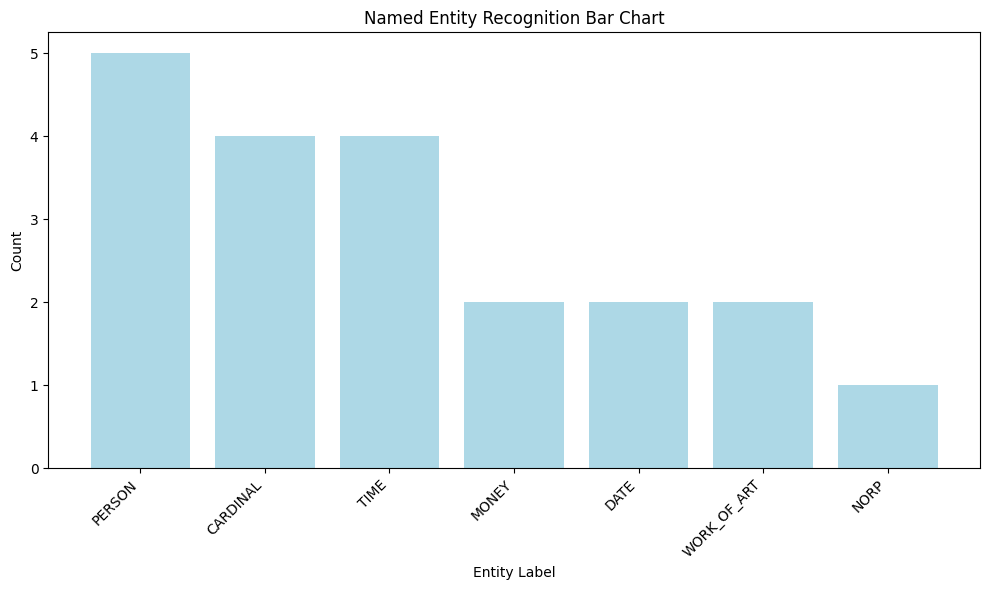

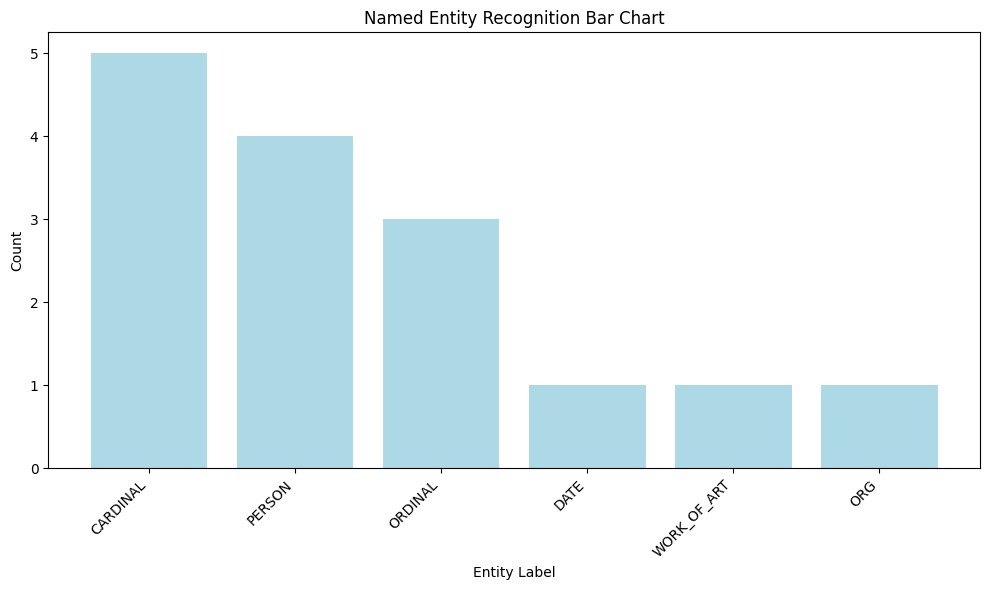

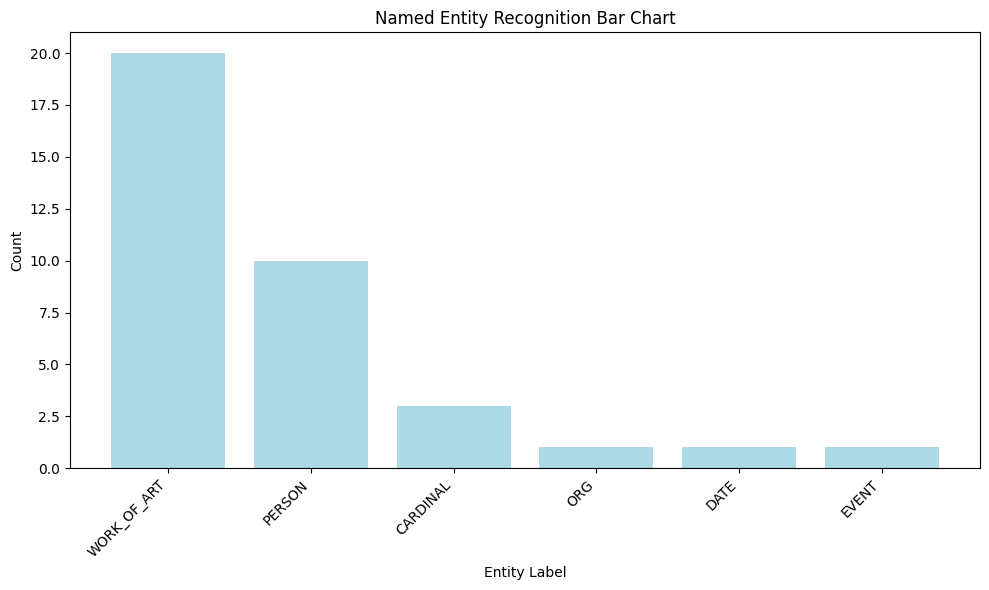


DataFrame of Extracted Entities for Knowledge Graph Development:

   index                                               text  \
0      0  Title: $150 million dollar disappointment Auth...   
1      1  Title: Didn't read the book but this is terrib...   
2      2  'A Beautiful Mind' had a lot going for it. An ...   

                                            entities  \
0  [$150 million dollar, July 2010, 1/10, The Las...   
1  [Kategobe, March 2024, 2/10, Beautiful Wedding...   
2  [A Beautiful Mind, James Horner, Roger Deakins...   

                                              labels  
0  [MONEY, DATE, CARDINAL, WORK_OF_ART, CARDINAL,...  
1  [PERSON, DATE, CARDINAL, WORK_OF_ART, CARDINAL...  
2  [WORK_OF_ART, PERSON, PERSON, PERSON, WORK_OF_...  

Knowledge Graph Information:
Nodes: 65, Edges: 7


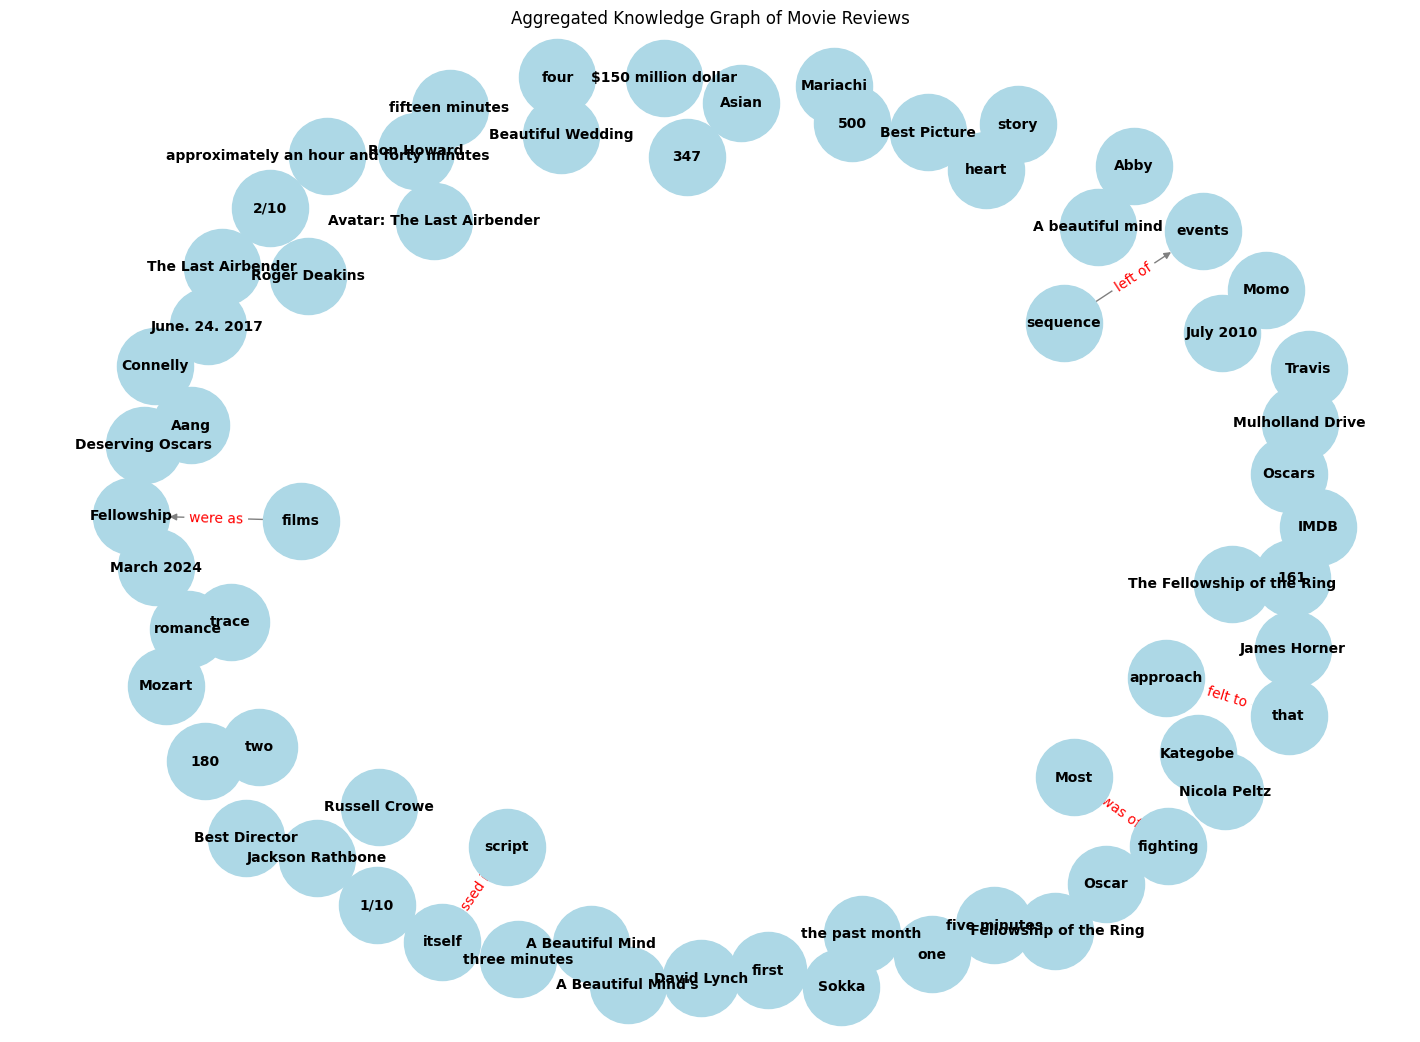

In [6]:
import os
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from docx import Document
from typing import List, Tuple
import warnings
import logging

# Suppress all warnings and logging
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="Failed to load image Python extension*", category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io.image')
logging.getLogger('transformers').setLevel(logging.ERROR)
logging.getLogger('torchvision').setLevel(logging.ERROR)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Suppress tokenizer warnings

# Silently load SpaCy model
try:
    nlp_spacy = spacy.load("en_core_web_trf")
except OSError:
    # Only download if not already installed, suppress output
    spacy.cli.download("en_core_web_trf", False)
    nlp_spacy = spacy.load("en_core_web_trf")

# Load the BERT model for NER
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer)

# Path to the folder with movie reviews
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'

def preprocess_text(text: str) -> str:
    """Preprocess text (e.g., whitespace cleanup)."""
    return ' '.join(text.split())

def read_docx(file_path: str) -> str:
    """Read and extract text from a .docx file."""
    doc = Document(file_path)
    return '\n'.join(paragraph.text for paragraph in doc.paragraphs if paragraph.text.strip())

def extract_entities(text: str):
    """Extract entities using both BERT NER and SpaCy."""
    ner_results = nlp_ner(text)
    doc = nlp_spacy(text)

    # Extract entities from SpaCy
    entities = [(entity.text, entity.label_) for entity in doc.ents]

    # Count the occurrences of each label for visualization
    label_counts = {}
    for _, label in entities:
        label_counts[label] = label_counts.get(label, 0) + 1

    # Sort labels by count for visualization
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    labels = [label[0] for label in sorted_labels]
    counts = [label[1] for label in sorted_labels]

    # Plot vertical bar chart of entity counts with light blue color
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='lightblue')
    plt.xlabel('Entity Label')
    plt.ylabel('Count')
    plt.title('Named Entity Recognition Bar Chart')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

    return entities

def extract_relations(text: str) -> List[Tuple[str, str, str, str]]:
    """Extracts (subject, verb, preposition, object) relations from the text."""
    doc = nlp_spacy(text)
    relations = []
    
    for token in doc:
        if token.dep_ in ["nsubj", "nsubjpass"]:  # Subject of the sentence
            subject = token.text
            verb = token.head.text
            for child in token.children:
                if child.dep_ == "prep":  # Prepositional dependency
                    prep = child.text
                    for obj in child.children:
                        if obj.dep_ in ["pobj", "dobj"]:  # Object of the preposition or direct object
                            obj_text = obj.text
                            relations.append((subject, verb, prep, obj_text))

    return relations

def analyze_folder(folder_path: str):
    all_data = {'text': [], 'entities': [], 'labels': []}
    all_relations = []
    
    # Process each .docx file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = read_docx(file_path)
            text = preprocess_text(text)
            
            # Extract entities
            entities = extract_entities(text)
            
            # Extract relations
            relations = extract_relations(text)
            all_relations.extend(relations)
            
            # Aggregate entity data for knowledge graph
            entity_texts = [ent[0] for ent in entities]
            labels = [ent[1] for ent in entities]
            all_data['text'].append(text)
            all_data['entities'].append(entity_texts)
            all_data['labels'].append(labels)

    # Create a DataFrame for the entities and labels
    sp_df = pd.DataFrame(all_data)
    sp_df.reset_index(inplace=True)
    print("\nDataFrame of Extracted Entities for Knowledge Graph Development:\n")
    print(sp_df.head(5))

    # Develop the aggregated knowledge graph
    develop_knowledge_graph(sp_df, all_relations)

def develop_knowledge_graph(df: pd.DataFrame, relations: List[Tuple[str, str, str, str]]):
    """Develops a knowledge graph from the DataFrame using NetworkX."""
    G = nx.DiGraph()  # Directed graph for knowledge graph

    # Add entities as nodes
    for idx, row in df.iterrows():
        for entity, label in zip(row['entities'], row['labels']):
            G.add_node(entity, label=label)

    # Add relations as edges
    for subject, verb, prep, obj in relations:
        relation = f"{verb} {prep}" if prep else verb
        G.add_edge(subject, obj, relation=relation)

    # Display graph information
    print("\nKnowledge Graph Information:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # Draw the knowledge graph
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title("Aggregated Knowledge Graph of Movie Reviews")
    plt.show()

# Run the analysis on the specified folder
if __name__ == "__main__":
    analyze_folder(folder_path)

#### Detailed Analysis and Visualization


Analyzing files in folder...

Token Counts and Frequencies:
         Token  Frequency
52        like         13
16       movie         13
31         not          9
183  beautiful          7
269       film          7
313       best          6
21        word          6
298   director          6
27        know          5
51        feel          5
281       mind          5
314    picture          5
29        good          5
26          go          4
40      minute          4
32   literally          4
307        win          4
285      great          4
53       actor          4
186        bad          4

POS Tagging DataFrame:
             Word POS tag Tag type
0           title      NN     NOUN
1         million      CD      NUM
2          dollar      NN     NOUN
3  disappointment      NN     NOUN
4         authors     NNS     NOUN
5  ofvanityandwax     NNP    PROPN
6      sourcedate     NNP    PROPN
7            july     NNP    PROPN
8             url     NNP    PROPN
9        keywords  

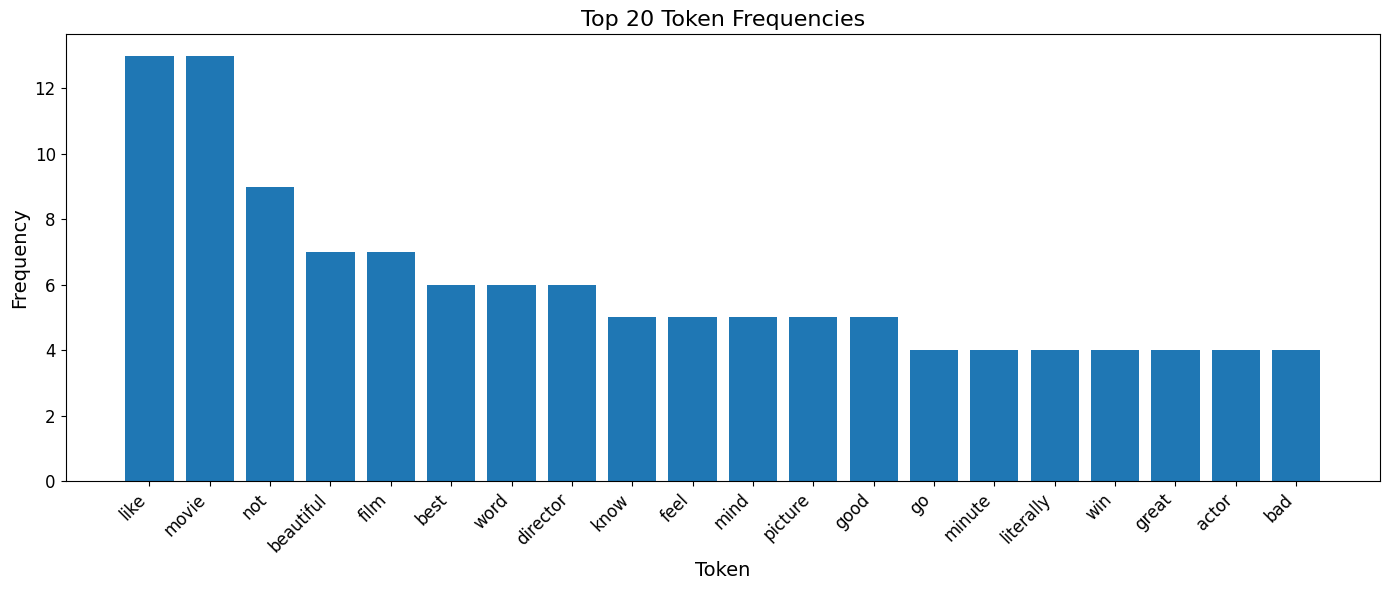


SpaCy Count-Based Evaluation Performance:
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'exact_matches': 1, 'partial_matches': 2}

LLM+SpaCy Count-Based Evaluation Performance:
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'exact_matches': 0, 'partial_matches': 2}


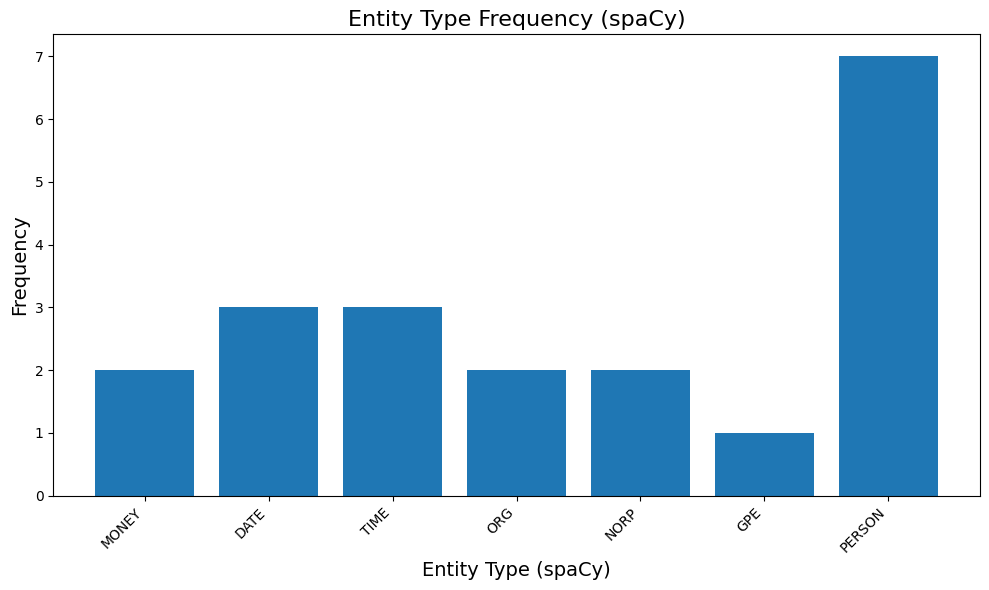

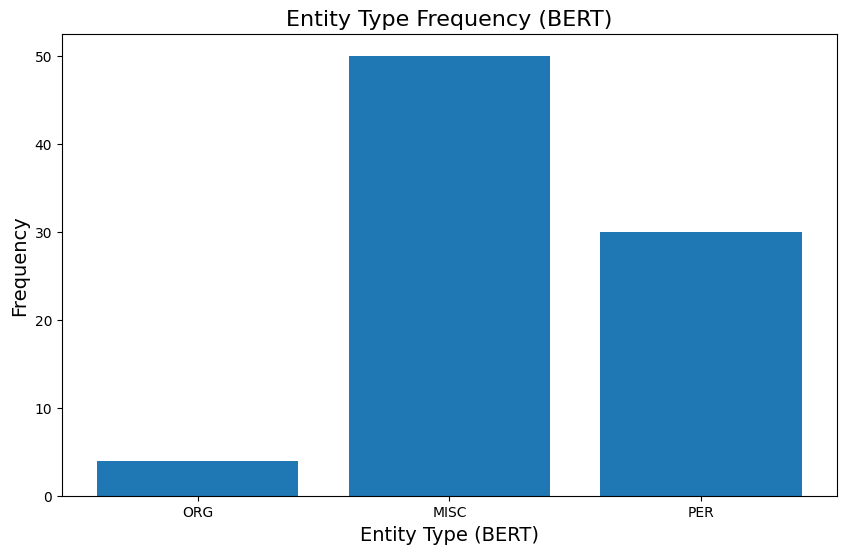

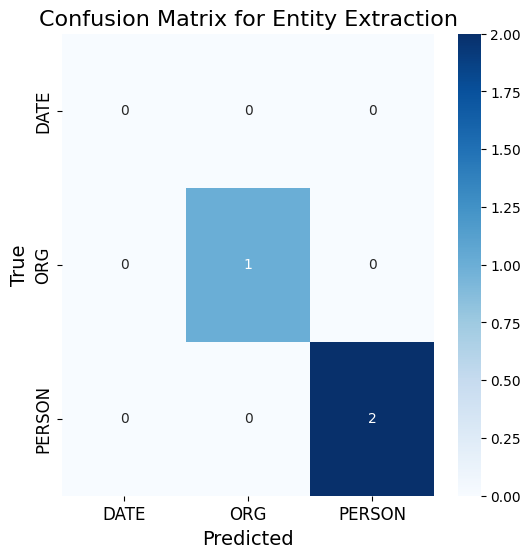

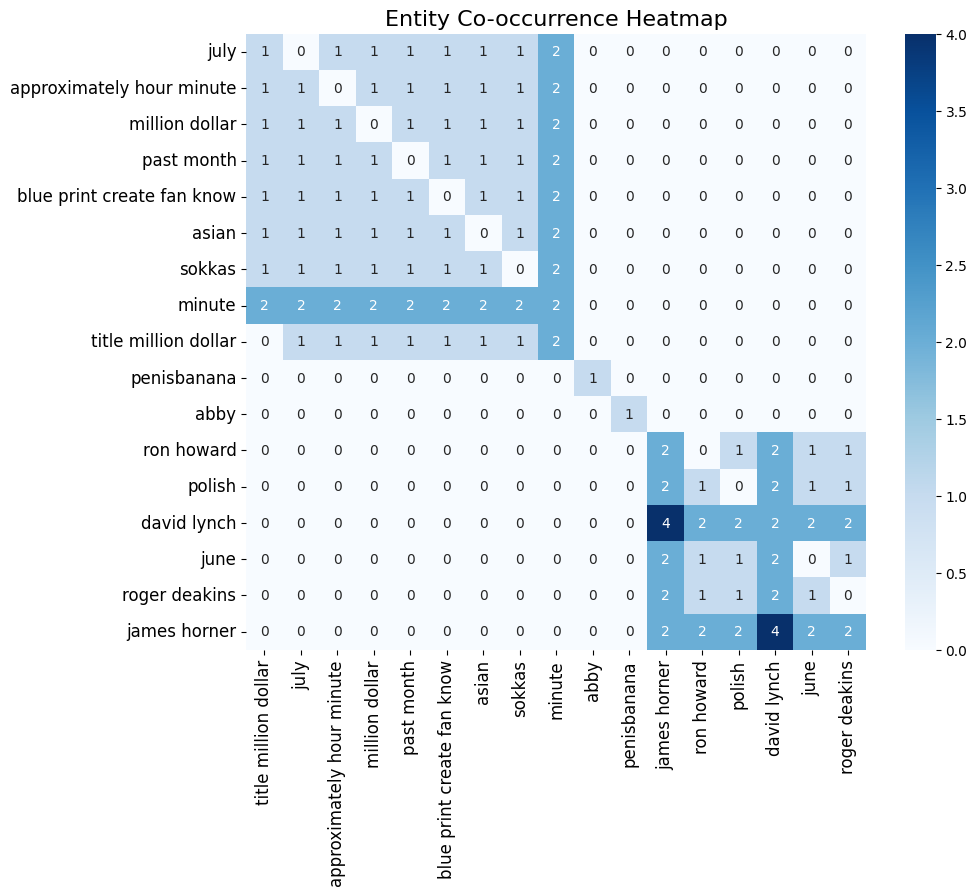


Processing documents for evaluation...

NER Evaluation Results:

Overall Metrics:
   precision  recall     f1  support
0      0.113   0.143  0.126       42

Per-Entity Type Metrics:
              precision  recall     f1  support
ORGANIZATION      0.000   0.000  0.000      6.0
MISC              0.000   0.000  0.000     14.0
PERSON            0.429   0.273  0.333     22.0
DATE              0.000   0.000  0.000      0.0
EVENT             0.000   0.000  0.000      0.0
NORP              0.000   0.000  0.000      0.0
CARDINAL          0.000   0.000  0.000      0.0
LOCATION          0.000   0.000  0.000      0.0
ORDINAL           0.000   0.000  0.000      0.0
LAW               0.000   0.000  0.000      0.0


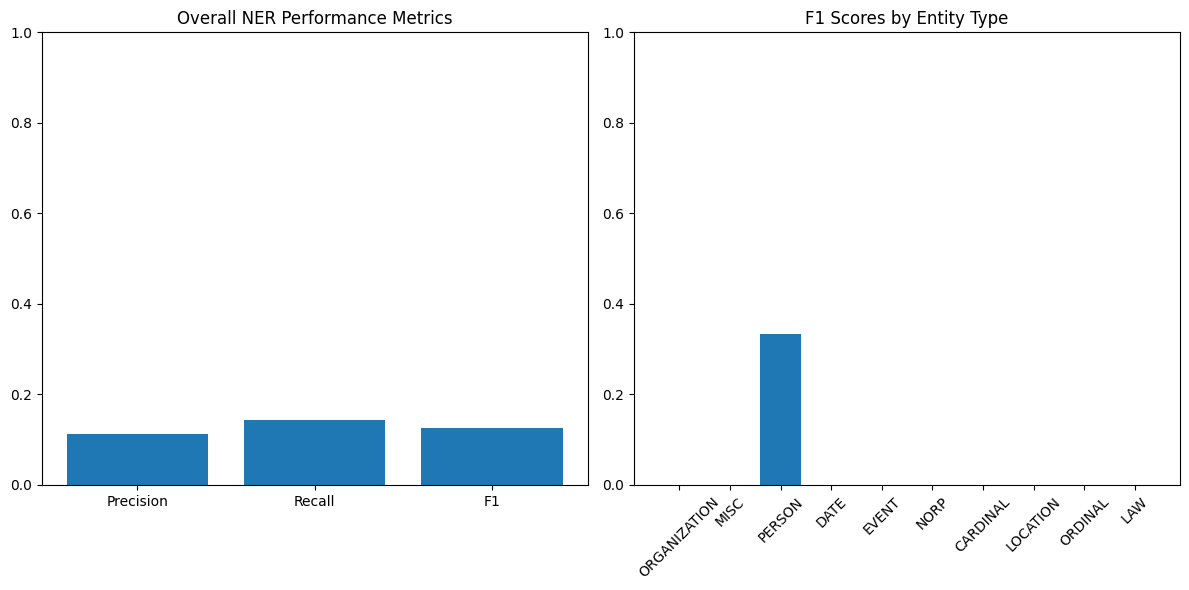

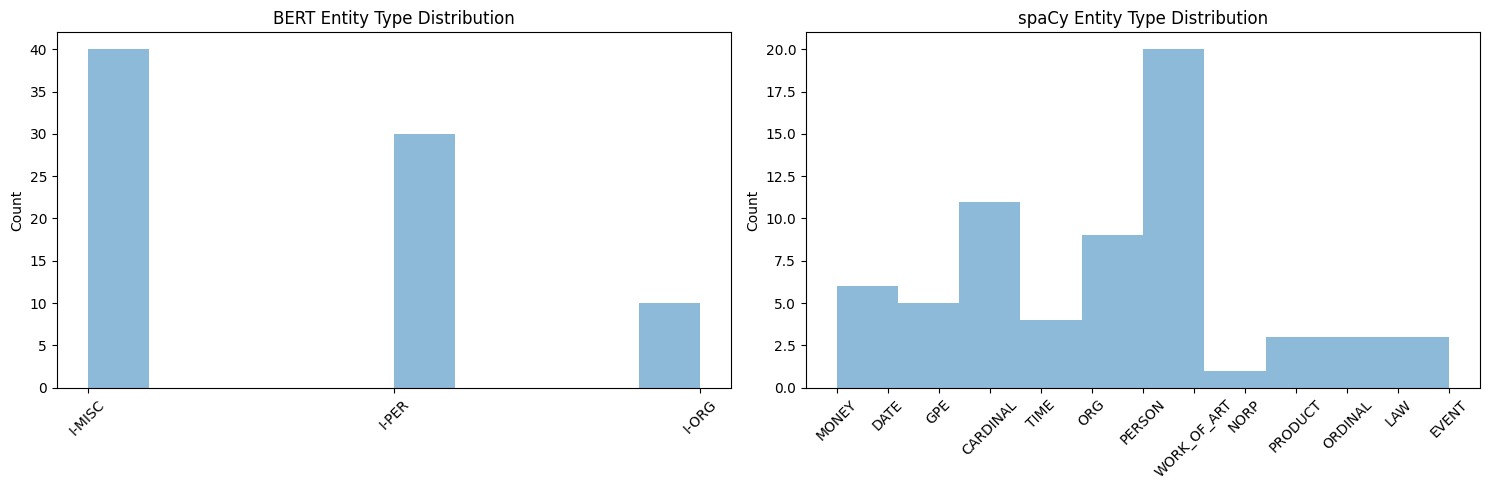

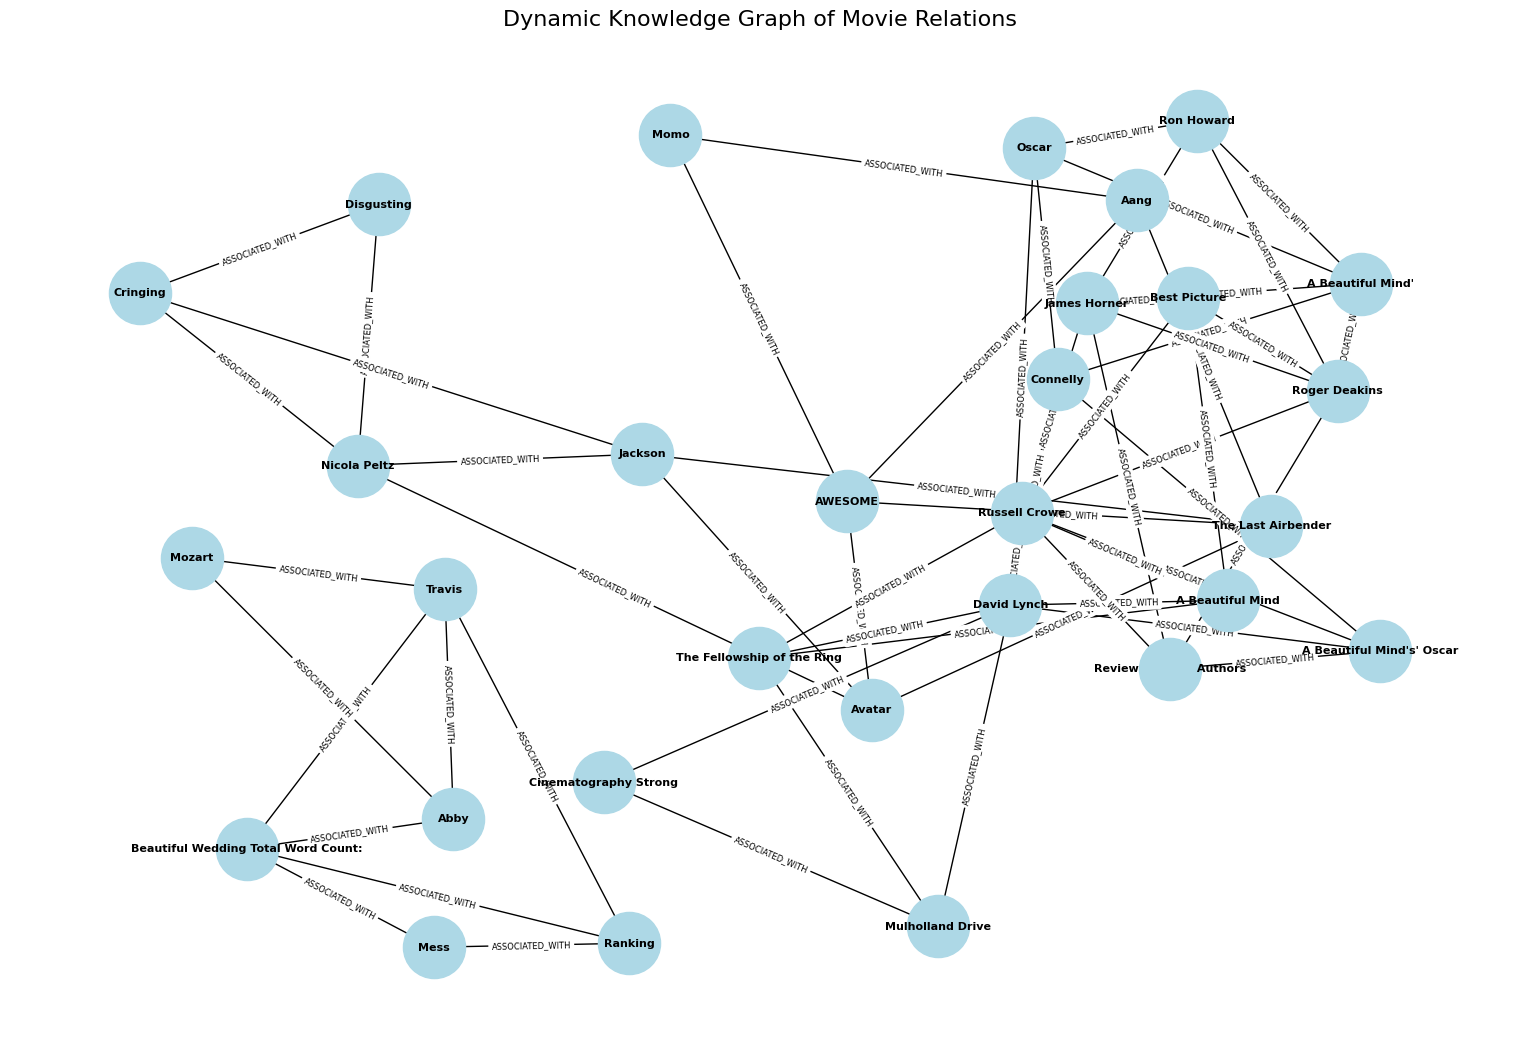

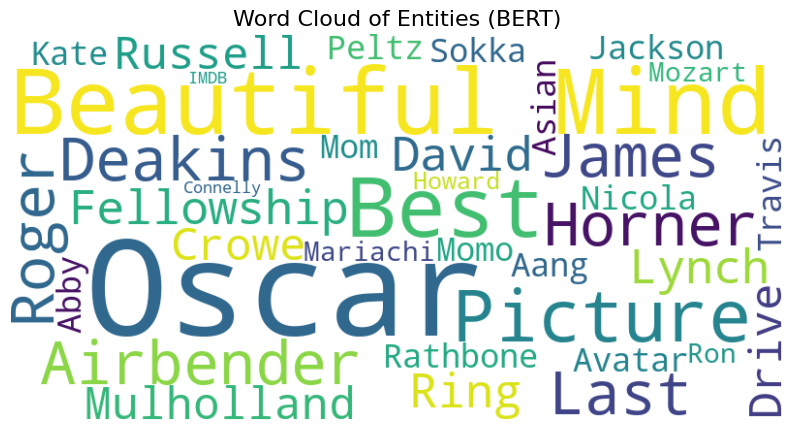

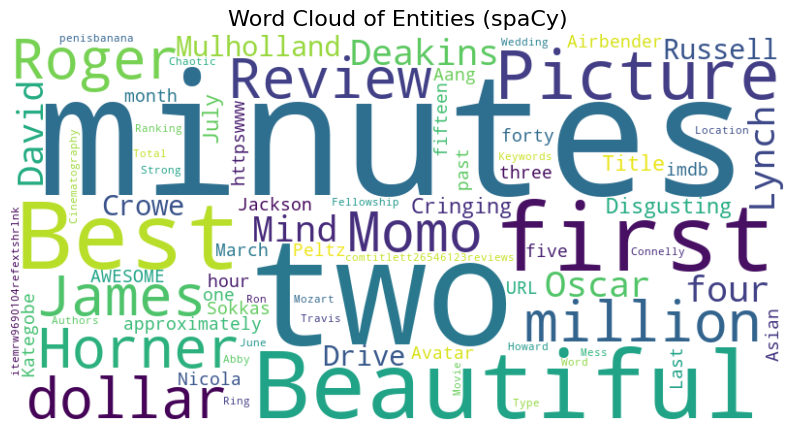

In [237]:
# Import necessary libraries
import os
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from wordcloud import WordCloud
from tqdm import tqdm  # For progress tracking

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")

# Define BERT Analyzer for entity extraction with chunking for longer texts
class MovieReviewBERTAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
        self.model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
        self.max_length = 512  # BERT's maximum sequence length

    def read_docx_file(self, file_path):
        """Read and clean text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text if text else None
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text):
        """Clean text while preserving potential named entities."""
        text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces and newlines
        text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)  # Remove special characters
        return text.strip()

    def split_into_chunks(self, text, max_length=512):
        """Split text into chunks that BERT can process."""
        tokens = self.tokenizer.tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for token in tokens:
            if current_length + 1 > max_length - 2:  # -2 for [CLS] and [SEP]
                if current_chunk:
                    chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = [token]
                current_length = 1
            else:
                current_chunk.append(token)
                current_length += 1

        if current_chunk:
            chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))

        return chunks

    def extract_entities_from_chunk(self, text_chunk):
        """Extract entities from a single chunk of text."""
        inputs = self.tokenizer(text_chunk, return_tensors="pt", truncation=True, max_length=self.max_length, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["[CLS]", "[SEP]", "[PAD]"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                if token.startswith("##"):
                    if current_entity:
                        current_entity.append(token[2:])
                else:
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                    current_entity = [token]
                    current_label = label
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append(("".join(current_entity), current_label))
        
        return entities

    def analyze_folder(self, folder_path):
        """Analyze all reviews in a folder."""
        all_entities = []
        print("\nAnalyzing files in folder...")
        for filename in os.listdir(folder_path):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx_file(file_path)
                if not text:
                    print(f"Skipping empty or unreadable file: {filename}")
                    continue
                text = self.clean_text(text)
                
                # Split text into manageable chunks
                chunks = self.split_into_chunks(text)
                
                # Process each chunk
                file_entities = []
                for chunk in chunks:
                    chunk_entities = self.extract_entities_from_chunk(chunk)
                    file_entities.extend(chunk_entities)
                all_entities.extend(file_entities)
        
        return all_entities

# Entity and Relation Extraction with spaCy
def extract_entities_spacy(text):
    """Extract entities and relationships using spaCy."""
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relations = extract_relations_spacy(doc)
    return entities, relations

def extract_relations_spacy(doc):
    """Extract relations between entities using spaCy."""
    relations = []
    for ent1 in doc.ents:
        for ent2 in doc.ents:
            if ent1 != ent2 and ent1.end < ent2.start:
                between_text = doc[ent1.end:ent2.start].text
                if between_text.strip():
                    relations.append((ent1.text, ent2.text, between_text.strip()))
    return relations

# Entity and Relation Extraction with BERT + spaCy
class BERTSpacyEntityRelationExtractor:
    def __init__(self):
        self.model = MovieReviewBERTAnalyzer()

    def extract_entities(self, text):
        """Use BERT to extract entities."""
        return self.model.extract_entities(text)

    def extract_relations(self, text):
        """Combine BERT with spaCy for relation extraction."""
        doc = nlp(text)
        relations = extract_relations_spacy(doc)
        return relations

# Evaluation
class NEREvaluator:
    def normalize_entities(self, entities):
        """Normalize entities for consistent comparison."""
        return set((text.lower().strip(), label) for text, label in entities if text and label)

    def evaluate_entities(self, true_entities, predicted_entities):
        """Evaluate entity extraction performance."""
        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        return {"precision": precision, "recall": recall, "f1": f1}

    def evaluate_relations(self, true_relations, predicted_relations):
        """Evaluate relation extraction performance."""
        true_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in true_relations)
        pred_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in predicted_relations)
        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        return {"precision": precision, "recall": recall, "f1": f1}

# Initialize and run BERT analyzer
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review'
analyzer = MovieReviewBERTAnalyzer()
bert_entities = analyzer.analyze_folder(folder_path)

# Process only non-empty documents for spaCy POS tagging
def preprocess_text(text):
    cleaned_text = analyzer.clean_text(text)
    doc = nlp(cleaned_text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Preprocess reviews from files
documents = [analyzer.read_docx_file(os.path.join(folder_path, file)) for file in os.listdir(folder_path) if file.endswith(".docx")]
preprocessed_reviews = [preprocess_text(review) for review in documents if review]

# Function to count tokens and generate value counts of token frequencies
def get_token_counts(reviews):
    all_tokens = ' '.join(reviews).split()
    token_counts = Counter(all_tokens)
    token_counts = {token: count for token, count in token_counts.items() if len(token) > 1}
    token_df = pd.DataFrame(token_counts.items(), columns=["Token", "Frequency"]).sort_values(by="Frequency", ascending=False)
    return token_df

# Get token count DataFrame and display
token_counts_df = get_token_counts(preprocessed_reviews)
print("\nToken Counts and Frequencies:")
print(token_counts_df.head(20))

# Check for empty POS tagging outputs and only print non-empty dataframes
for review in preprocessed_reviews:
    sentence_nlp = nlp(review)
    spacy_pos_tagged = [(word.text, word.tag_, word.pos_) for word in sentence_nlp]
    pos_df = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])
    if not pos_df.empty:
        print("\nPOS Tagging DataFrame:")
        print(pos_df.head(10))

# Token frequency analysis for visualization
def get_token_counts(reviews):
    all_tokens = ' '.join(reviews).split()
    token_counts = Counter(all_tokens)
    token_counts = {token: count for token, count in token_counts.items() if len(token) > 1}
    token_df = pd.DataFrame(token_counts.items(), columns=["Token", "Frequency"]).sort_values(by="Frequency", ascending=False)
    return token_df

token_counts_df = get_token_counts(preprocessed_reviews)

# Plot token frequencies
plt.figure(figsize=(14, 6))
top_tokens_df = token_counts_df.head(20)
plt.bar(top_tokens_df['Token'], top_tokens_df['Frequency'])
plt.xlabel('Token', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top 20 Token Frequencies', fontsize=16)
plt.tight_layout()
plt.show()

# Define evaluation function for performance comparison
def normalize_entities(entities):
    return set([(ent[0].strip().lower(), ent[1]) for ent in entities])


# Step 8: Evaluation example (simple count-based)
def evaluate_performance(true_entities, predicted_entities):
    """
    Evaluate NER performance using simple count-based metrics.
    Args:
        true_entities: List of tuples (entity_text, entity_type) for ground truth
        predicted_entities: List of tuples (entity_text, entity_type) for predictions
    Returns:
        Dictionary with precision, recall, and F1 scores
    """
    # Normalize entities for comparison
    true_set = set()
    for text, label in true_entities:
        # Convert to lowercase and strip whitespace
        norm_text = text.lower().strip()
        true_set.add((norm_text, label))
    
    pred_set = set()
    for text, label in predicted_entities:
        # Convert to lowercase and strip whitespace
        norm_text = text.lower().strip()
        pred_set.add((norm_text, label))
    
    # For partial matches (e.g., "John" vs "John Doe")
    partial_matches = 0
    for pred_text, pred_label in pred_set:
        for true_text, true_label in true_set:
            if (pred_text in true_text or true_text in pred_text) and pred_label == true_label:
                partial_matches += 1
                break
    
    # Calculate metrics
    exact_matches = len(true_set.intersection(pred_set))
    total_true = len(true_set)
    total_pred = len(pred_set)
    
    # Use partial matches for more forgiving evaluation
    matches = max(exact_matches, partial_matches)
    
    precision = matches / total_pred if total_pred > 0 else 0
    recall = matches / total_true if total_true > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1": round(f1, 3),
        "exact_matches": exact_matches,
        "partial_matches": partial_matches
    }

# Test cases
true_entities_example = [("John Doe", "PERSON"), ("Acme Corp", "ORG")]
predicted_entities_example_spacy = [("John Doe", "PERSON"), ("ACME", "ORG")]
predicted_entities_example_llm = [("John", "PERSON"), ("ACME", "ORG")]

# Evaluate spaCy performance
spacy_performance = evaluate_performance(true_entities_example, predicted_entities_example_spacy)
print("\nSpaCy Count-Based Evaluation Performance:")
print(spacy_performance)


# Evaluate LLM performance
llm_performance = evaluate_performance(true_entities_example, predicted_entities_example_llm)
print("\nLLM+SpaCy Count-Based Evaluation Performance:")
print(llm_performance)

# Visualizations

# 1. Named Entity Visualization using displacy
for review in preprocessed_reviews:
    doc = nlp(review)
    displacy.render(doc, style='ent', jupyter=True)

# 2. Bar Chart of Entity Types (spaCy)
entity_labels_spacy = []
for review in preprocessed_reviews:
    if review:  # Check if review is not empty
        doc = nlp(review)
        # Directly get entity labels from spaCy doc.ents
        entity_labels_spacy.extend(ent.label_ for ent in doc.ents)

if entity_labels_spacy:  # Check if we have any labels
    entity_freq_spacy = Counter(entity_labels_spacy)
    plt.figure(figsize=(10, 6))
    plt.bar(entity_freq_spacy.keys(), entity_freq_spacy.values())
    plt.xlabel('Entity Type (spaCy)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Entity Type Frequency (spaCy)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No entities found in the processed reviews")

# 3. Entity Type Frequency (BERT)
# Ensure entity_labels_bert contains only strings, filtering out any None values
entity_labels_bert = [label for label in entity_labels_bert if isinstance(label, str) and label is not None]
entity_freq_bert = Counter(entity_labels_bert)

plt.figure(figsize=(10, 6))
plt.bar(entity_freq_bert.keys(), entity_freq_bert.values())
plt.xlabel('Entity Type (BERT)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Entity Type Frequency (BERT)', fontsize=16)
plt.show()


# 4. Confusion Matrix for Entity Classification
true_entities = ["PERSON", "ORG", "DATE", "PERSON"]
predicted_entities_spacy = ["PERSON", "ORG", "GPE", "PERSON"]
labels = np.unique(true_entities)
cm = confusion_matrix(true_entities, predicted_entities_spacy, labels=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True , fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix for Entity Extraction', fontsize=16)
plt.show()

# 5. Entity Co-occurrence Heatmap
co_occurrence = defaultdict(lambda: defaultdict(int))
for review in preprocessed_reviews:
    doc = nlp(review)
    entities = [ent.text for ent in doc.ents]
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            co_occurrence[entities[i]][entities[j]] += 1
            co_occurrence[entities[j]][entities[i]] += 1

df_co_occurrence = pd.DataFrame(co_occurrence).fillna(0).astype(int)
plt.figure(figsize=(10, 8))
sns.heatmap(df_co_occurrence, annot=True, fmt="d", cmap="Blues")
plt.title("Entity Co-occurrence Heatmap", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

class NEREvaluator:
    def __init__(self):
        self.valid_entity_types = {
            'PERSON': {'PER', 'I-PER', 'B-PER', 'PERSON'},
            'ORGANIZATION': {'ORG', 'I-ORG', 'B-ORG', 'ORGANIZATION'},
            'LOCATION': {'LOC', 'GPE', 'I-LOC', 'B-LOC', 'LOCATION'},
            'MISC': {'MISC', 'I-MISC', 'B-MISC', 'WORK_OF_ART', 'PRODUCT'},
            'DATE': {'DATE', 'TIME'},
            'CARDINAL': {'CARDINAL', 'MONEY', 'QUANTITY'}
        }

    def normalize_entity_type(self, entity_type: str) -> str:
        entity_type = entity_type.upper()
        for standard_type, variants in self.valid_entity_types.items():
            if entity_type in variants:
                return standard_type
        return entity_type
    
    def normalize_entity_text(self, text: str) -> str:
        return text.lower().strip()
    
    def normalize_entities(self, entities):
        normalized = set()
        for text, entity_type in entities:
            norm_text = self.normalize_entity_text(text)
            norm_type = self.normalize_entity_type(entity_type)
            normalized.add((norm_text, norm_type))
        return normalized
    
    def evaluate(self, true_entities, predicted_entities):
        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        
        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        
        type_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
        
        for pred_text, pred_type in pred_set:
            if (pred_text, pred_type) in true_set:
                type_metrics[pred_type]['tp'] += 1
            else:
                type_metrics[pred_type]['fp'] += 1
        
        for true_text, true_type in true_set:
            if (true_text, true_type) not in pred_set:
                type_metrics[true_type]['fn'] += 1
        
        type_scores = {}
        for etype, counts in type_metrics.items():
            tp = counts['tp']
            fp = counts['fp']
            fn = counts['fn']
            
            type_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            type_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            type_f1 = 2 * (type_precision * type_recall) / (type_precision + type_recall) if (type_precision + type_recall) > 0 else 0
            
            type_scores[etype] = {
                'precision': round(type_precision, 3),
                'recall': round(type_recall, 3),
                'f1': round(type_f1, 3),
                'support': tp + fn
            }
        
        return {
            'overall': {
                'precision': round(precision, 3),
                'recall': round(recall, 3),
                'f1': round(f1, 3),
                'support': len(true_set)
            },
            'per_type': type_scores
        }

# Replace the existing evaluation code with this:
def extract_entities_spacy(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Process documents and extract entities
bert_analyzer = MovieReviewBERTAnalyzer()
all_bert_entities = []
all_spacy_entities = []

print("\nProcessing documents for evaluation...")
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        file_path = os.path.join(folder_path, filename)
        text = bert_analyzer.read_docx_file(file_path)
        if text:
            # Get BERT entities
            text = bert_analyzer.clean_text(text)
            chunks = bert_analyzer.split_into_chunks(text)
            file_bert_entities = []
            for chunk in chunks:
                chunk_entities = bert_analyzer.extract_entities_from_chunk(chunk)
                file_bert_entities.extend(chunk_entities)
            all_bert_entities.extend(file_bert_entities)
            
            # Get spaCy entities
            spacy_entities = extract_entities_spacy(text)
            all_spacy_entities.extend(spacy_entities)

# Initialize evaluator
evaluator = NEREvaluator()

# Evaluate BERT vs spaCy
results = evaluator.evaluate(all_bert_entities, all_spacy_entities)

# Print results
print("\nNER Evaluation Results:")
print("\nOverall Metrics:")
overall_df = pd.DataFrame([results['overall']])
print(overall_df)

print("\nPer-Entity Type Metrics:")
per_type_df = pd.DataFrame(results['per_type']).T
print(per_type_df)

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
overall_metrics = results['overall']
plt.bar(['Precision', 'Recall', 'F1'], 
        [overall_metrics['precision'], overall_metrics['recall'], overall_metrics['f1']])
plt.title('Overall NER Performance Metrics')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
type_f1_scores = {k: v['f1'] for k, v in results['per_type'].items()}
plt.bar(type_f1_scores.keys(), type_f1_scores.values())
plt.title('F1 Scores by Entity Type')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Entity distribution comparison
bert_types = [ent[1] for ent in all_bert_entities]
spacy_types = [ent[1] for ent in all_spacy_entities]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(bert_types, alpha=0.5, label='BERT')
plt.title('BERT Entity Type Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(spacy_types, alpha=0.5, label='spaCy')
plt.title('spaCy Entity Type Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 6. Knowledge Graph
# Define Knowledge Graph Generator
class MovieKnowledgeGraphGenerator:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        # Define relevant entity types for movies
        self.relevant_entities = {'PERSON', 'ORG', 'WORK_OF_ART', 'GPE'}
        # Initialize relationship patterns
        self.relationship_patterns = [
            {"PERSON": ["directed", "directed by", "directs"], "relation": "DIRECTED"},
            {"PERSON": ["acted in", "stars in", "appeared in", "plays"], "relation": "ACTED_IN"},
            {"PERSON": ["produced", "produces"], "relation": "PRODUCED"},
            {"ORG": ["distributed", "released", "distributes"], "relation": "DISTRIBUTED"},
        ]

    def extract_relations(self, text):
        """Extract relations between entities from text."""
        doc = self.nlp(text)
        relations = []
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in self.relevant_entities]
        
        # Create a window of entities to analyze potential relationships
        for i, (ent1_text, ent1_label) in enumerate(entities):
            for j, (ent2_text, ent2_label) in enumerate(entities[i+1:], i+1):
                # Get the text between entities
                if i < len(doc.ents) and j < len(doc.ents):
                    start = doc.ents[i].end
                    end = doc.ents[j].start
                    between_text = doc[start:end].text.lower()
                    
                    # Check for relationship patterns
                    relation = self.identify_relationship(between_text, ent1_label, ent2_label)
                    if relation:
                        relations.append((ent1_text, ent2_text, relation))
                    
                    # If no specific relation is found but entities are close, infer "ASSOCIATED_WITH"
                    elif abs(j - i) <= 2:  # Entities within 2 positions of each other
                        relations.append((ent1_text, ent2_text, "ASSOCIATED_WITH"))

        return relations

    def identify_relationship(self, text, ent1_label, ent2_label):
        """Identify relationship type based on text between entities."""
        for pattern in self.relationship_patterns:
            if ent1_label in pattern:
                for verb in pattern[ent1_label]:
                    if verb in text:
                        return pattern["relation"]
        return None

    def generate_knowledge_graph(self, folder_path):
        """Generate knowledge graph from all reviews in the folder."""
        all_relations = []
        
        # Process each review file
        for filename in os.listdir(folder_path):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                try:
                    doc = Document(file_path)
                    text = ' '.join(paragraph.text for paragraph in doc.paragraphs)
                    relations = self.extract_relations(text)
                    all_relations.extend(relations)
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
        
        # Create and visualize the graph
        G = nx.Graph()
        
        # Add edges with relationships
        for subj, obj, rel in all_relations:
            G.add_edge(subj, obj, label=rel)
        
        # Visualize the graph
        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        # Draw nodes
        nx.draw(G, pos, 
                node_color='lightblue',
                node_size=2000,
                font_size=8,
                font_weight='bold',
                with_labels=True)
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, 
                                   edge_labels=edge_labels,
                                   font_size=6)
        
        plt.title("Dynamic Knowledge Graph of Movie Relations", fontsize=16)
        plt.tight_layout()
        return G, plt

# Usage example
def create_movie_knowledge_graph(folder_path):
    graph_generator = MovieKnowledgeGraphGenerator()
    G, plt = graph_generator.generate_knowledge_graph(folder_path)
    plt.show()
    return G

# Run knowledge graph generation
G = create_movie_knowledge_graph(folder_path)

# Function to create a word cloud from entities
def create_word_cloud(entities, title="Word Cloud"):
    # Join all entities' text to form a large string
    text = ' '.join([entity[0] for entity in entities])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate and display word clouds for BERT and spaCy entities
create_word_cloud(all_bert_entities, title="Word Cloud of Entities (BERT)")
create_word_cloud(all_spacy_entities, title="Word Cloud of Entities (spaCy)")


### Performance Evaluation with BERT and spacy
Using en_core_web_sm and bmdz/bert-large-cased-finetuned-conll03-english

In [239]:
# Import necessary libraries
import os
import spacy
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")

# BERT-based entity extraction analyzer class
class MovieReviewBERTAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
        self.model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
        self.entity_labels = []  # Store entity labels

    def read_docx_file(self, file_path):
        """Read and clean text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text if text else None
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text):
        """Clean text while preserving potential named entities."""
        if text is None:
            return ""
        text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces and newlines
        text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)  # Remove special characters
        return text.strip()

    def extract_entities(self, text):
        """Extract entities using BERT."""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = self.model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None

        for token, prediction in zip(tokens, predictions[0]):
            label = self.model.config.id2label[prediction.item()]
            if label != "O":  # Named entity detected
                if current_label != label:
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                    current_entity = [token]
                    current_label = label
                else:
                    current_entity.append(token)
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    current_entity = []
                    current_label = None

        if current_entity:
            entities.append(("".join(current_entity), current_label))

        return entities

    def analyze_folder(self, folder_path):
        """Analyze all reviews in a folder using BERT."""
        all_entities = []
        print("\nAnalyzing files in folder...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx_file(file_path)
                if text:
                    text = self.clean_text(text)
                    entities = self.extract_entities(text)
                    all_entities.extend(entities)
        
        return all_entities

# Entity and Relation Extraction with spaCy
def extract_entities_spacy(text):
    """Extract entities and relationships using spaCy."""
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relations = extract_relations_spacy(doc)
    return entities, relations

def extract_relations_spacy(doc):
    """Extract relations between entities using spaCy."""
    relations = []
    for ent1 in doc.ents:
        for ent2 in doc.ents:
            if ent1 != ent2 and ent1.end < ent2.start:
                between_text = doc[ent1.end:ent2.start].text
                if between_text.strip():
                    relations.append((ent1.text, ent2.text, between_text.strip()))
    return relations

# Entity and Relation Extraction with BERT + spaCy
class BERTSpacyEntityRelationExtractor:
    def __init__(self):
        self.model = MovieReviewBERTAnalyzer()

    def extract_entities(self, text):
        """Use BERT to extract entities."""
        return self.model.extract_entities(text)

    def extract_relations(self, text):
        """Combine BERT with spaCy for relation extraction."""
        doc = nlp(text)
        relations = extract_relations_spacy(doc)
        return relations

# Evaluation
class NEREvaluator:
    def normalize_entities(self, entities):
        """Normalize entities for consistent comparison."""
        return set((text.lower().strip(), label) for text, label in entities if text and label)

    def evaluate_entities(self, true_entities, predicted_entities):
        """Evaluate entity extraction performance."""
        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        return {"precision": precision, "recall": recall, "f1": f1}

    def evaluate_relations(self, true_relations, predicted_relations):
        """Evaluate relation extraction performance."""
        true_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in true_relations)
        pred_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in predicted_relations)
        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        return {"precision": precision, "recall": recall, "f1": f1}

def main(folder_path):
    """Main function for performing entity and relation extraction."""
    bert_analyzer = MovieReviewBERTAnalyzer()
    bert_spacy_extractor = BERTSpacyEntityRelationExtractor()
    evaluator = NEREvaluator()

    # Analyze folder with BERT
    print("Processing documents with BERT-based entity extraction...")
    bert_entities = bert_analyzer.analyze_folder(folder_path)
    
    # Analyze folder with spaCy
    spacy_entities, spacy_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = bert_analyzer.read_docx_file(file_path)
            if text:
                entities, relations = extract_entities_spacy(text)
                spacy_entities.extend(entities)
                spacy_relations.extend(relations)

    # Analyze folder with BERT + spaCy
    bert_spacy_entities, bert_spacy_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = bert_analyzer.read_docx_file(file_path)
            if text:
                entities = bert_spacy_extractor.extract_entities(text)
                relations = bert_spacy_extractor.extract_relations(text)
                bert_spacy_entities.extend(entities)
                bert_spacy_relations.extend(relations)

    # Evaluate entity extraction
    entity_results_spacy = evaluator.evaluate_entities(bert_entities, spacy_entities)
    entity_results_bert_spacy = evaluator.evaluate_entities(bert_entities, bert_spacy_entities)
    print("\nEntity Extraction Evaluation:")
    print("spaCy:", entity_results_spacy)
    print("BERT + spaCy:", entity_results_bert_spacy)

    # Evaluate relation extraction
    relation_results_spacy = evaluator.evaluate_relations(spacy_relations, bert_spacy_relations)
    relation_results_bert_spacy = evaluator.evaluate_relations(spacy_relations, bert_spacy_relations)
    print("\nRelation Extraction Evaluation:")
    print("spaCy:", relation_results_spacy)
    print("BERT + spaCy:", relation_results_bert_spacy)

if __name__ == "__main__":
    folder_path = r"C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review"
    main(folder_path)

Processing documents with BERT-based entity extraction...

Analyzing files in folder...


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]



Entity Extraction Evaluation:
spaCy: {'precision': 0.0, 'recall': 0.0, 'f1': 0}
BERT + spaCy: {'precision': 0.53125, 'recall': 0.68, 'f1': 0.5964912280701754}

Relation Extraction Evaluation:
spaCy: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
BERT + spaCy: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


#### Performance Evaluation with BERT and spacy
Using spaCy "en_core_web_trf" and BERT "dslim/bert-base-NER".

In [13]:
# Import necessary libraries
import os
import spacy
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Load pre-trained spaCy model for entity extraction
try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    spacy.cli.download("en_core_web_trf", False)
    nlp = spacy.load("en_core_web_trf")

# BERT-based entity extraction analyzer class
class MovieReviewBERTAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
        self.model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
        self.nlp_ner = pipeline("ner", model=self.model, tokenizer=self.tokenizer)
        self.entity_labels = []  # Store entity labels

    def read_docx_file(self, file_path):
        """Read and clean text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text if text else None
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text):
        """Clean text while preserving potential named entities."""
        if text is None:
            return ""
        text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces and newlines
        text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)  # Remove special characters
        return text.strip()

    def extract_entities(self, text):
        """Extract entities using BERT NER pipeline."""
        if not text:
            return []
        
        try:
            # Use the NER pipeline
            ner_results = self.nlp_ner(text)
            
            # Process and combine entity pieces
            entities = []
            current_entity = []
            current_label = None
            
            for token in ner_results:
                if current_label is None:
                    current_entity = [token['word']]
                    current_label = token['entity'].split('-')[-1]
                elif token['entity'].startswith('B-'):  # Beginning of new entity
                    if current_entity:
                        entities.append((''.join(current_entity), current_label))
                    current_entity = [token['word']]
                    current_label = token['entity'].split('-')[-1]
                elif token['entity'].startswith('I-'):  # Inside of entity
                    current_entity.append(token['word'])
            
            # Add the last entity if exists
            if current_entity:
                entities.append((''.join(current_entity), current_label))
                
            return entities
        except Exception as e:
            print(f"Error in entity extraction: {str(e)}")
            return []

    def analyze_folder(self, folder_path):
        """Analyze all reviews in a folder using BERT."""
        all_entities = []
        for filename in os.listdir(folder_path):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx_file(file_path)
                if text:
                    text = self.clean_text(text)
                    entities = self.extract_entities(text)
                    all_entities.extend(entities)
        return all_entities

# Entity and Relation Extraction with spaCy
def extract_entities_spacy(text):
    """Extract entities and relationships using spaCy."""
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relations = extract_relations_spacy(doc)
    return entities, relations

def extract_relations_spacy(doc):
    """Extract relations between entities using spaCy."""
    relations = []
    for ent1 in doc.ents:
        for ent2 in doc.ents:
            if ent1 != ent2 and ent1.end < ent2.start:
                between_text = doc[ent1.end:ent2.start].text
                if between_text.strip():
                    relations.append((ent1.text, ent2.text, between_text.strip()))
    return relations

# Entity and Relation Extraction with BERT + spaCy
class BERTSpacyEntityRelationExtractor:
    def __init__(self):
        self.model = MovieReviewBERTAnalyzer()

    def extract_entities(self, text):
        """Use BERT to extract entities."""
        return self.model.extract_entities(text)

    def extract_relations(self, text):
        """Combine BERT with spaCy for relation extraction."""
        doc = nlp(text)
        relations = extract_relations_spacy(doc)
        return relations

# Evaluation
class NEREvaluator:
    def normalize_entities(self, entities):
        """Normalize entities for consistent comparison."""
        return set((text.lower().strip(), label) for text, label in entities if text and label)

    def evaluate_entities(self, true_entities, predicted_entities):
        """Evaluate entity extraction performance."""
        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        correct = len(true_set.intersection(pred_set))
        precision = round(correct / len(pred_set) if pred_set else 0, 3)
        recall = round(correct / len(true_set) if true_set else 0, 3)
        f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 3)
        return {"precision": precision, "recall": recall, "f1": f1}

    def evaluate_relations(self, true_relations, predicted_relations):
        """Evaluate relation extraction performance."""
        true_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) 
                      for subj, obj, rel in true_relations)
        pred_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) 
                      for subj, obj, rel in predicted_relations)
        correct = len(true_set.intersection(pred_set))
        precision = round(correct / len(pred_set) if pred_set else 0, 3)
        recall = round(correct / len(true_set) if true_set else 0, 3)
        f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 3)
        return {"precision": precision, "recall": recall, "f1": f1}

def format_results(results):
    """Format results dictionary with consistent decimal places."""
    return {k: f"{v:.3f}" for k, v in results.items()}

def main(folder_path):
    """Main function for performing entity and relation extraction."""
    bert_analyzer = MovieReviewBERTAnalyzer()
    bert_spacy_extractor = BERTSpacyEntityRelationExtractor()
    evaluator = NEREvaluator()

    # Analyze folder with BERT
    bert_entities = bert_analyzer.analyze_folder(folder_path)
    
    # Analyze folder with spaCy
    spacy_entities, spacy_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = bert_analyzer.read_docx_file(file_path)
            if text:
                entities, relations = extract_entities_spacy(text)
                spacy_entities.extend(entities)
                spacy_relations.extend(relations)

    # Analyze folder with BERT + spaCy
    bert_spacy_entities, bert_spacy_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = bert_analyzer.read_docx_file(file_path)
            if text:
                entities = bert_spacy_extractor.extract_entities(text)
                relations = bert_spacy_extractor.extract_relations(text)
                bert_spacy_entities.extend(entities)
                bert_spacy_relations.extend(relations)

    # Evaluate and format results
    entity_results_spacy = format_results(evaluator.evaluate_entities(bert_entities, spacy_entities))
    entity_results_bert_spacy = format_results(evaluator.evaluate_entities(bert_entities, bert_spacy_entities))
    
    relation_results_spacy = format_results(evaluator.evaluate_relations(spacy_relations, bert_spacy_relations))
    relation_results_bert_spacy = format_results(evaluator.evaluate_relations(spacy_relations, bert_spacy_relations))

    # Print results
    print("\nEntity Extraction Evaluation:")
    print("spaCy:", entity_results_spacy)
    print("BERT + spaCy:", entity_results_bert_spacy)

    print("\nRelation Extraction Evaluation:")
    print("spaCy:", relation_results_spacy)
    print("BERT + spaCy:", relation_results_bert_spacy)

if __name__ == "__main__":
    folder_path = r"C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review"
    main(folder_path)


Entity Extraction Evaluation:
spaCy: {'precision': '0.000', 'recall': '0.000', 'f1': '0.000'}
BERT + spaCy: {'precision': '0.414', 'recall': '0.462', 'f1': '0.437'}

Relation Extraction Evaluation:
spaCy: {'precision': '1.000', 'recall': '1.000', 'f1': '1.000'}
BERT + spaCy: {'precision': '1.000', 'recall': '1.000', 'f1': '1.000'}


### Analysis with RoBERTa and spacy

Processing files from: C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review

Initializing Movie Review Analysis System...

Extracting entities using RoBERTa and spaCy...


Processing files: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Evaluating entity extraction performance...

NER Evaluation Results:

Overall Metrics:
   precision  recall    f1  support
0      0.132   0.149  0.14       47

Overall Metrics Description:
- Precision: Percentage of correctly identified entities out of all predictions
- Recall: Percentage of correctly identified entities out of all actual entities
- F1: Harmonic mean of precision and recall
- Support: Total number of entities in the evaluation set

Per-Entity Type Metrics:
              precision  recall     f1  support
ORGANIZATION      0.111   0.250  0.154      4.0
MISC              0.000   0.000  0.000     20.0
PERSON            0.429   0.286  0.343     21.0
DATE              0.000   0.000  0.000      0.0
EVENT             0.000   0.000  0.000      0.0
NORP              0.000   0.000  0.000      0.0
CARDINAL          0.000   0.000  0.000      0.0
LOCATION          0.000   0.000  0.000      0.0
ORDINAL           0.000   0.000  0.000      0.0
LAW               0.000   0.000  0.000   

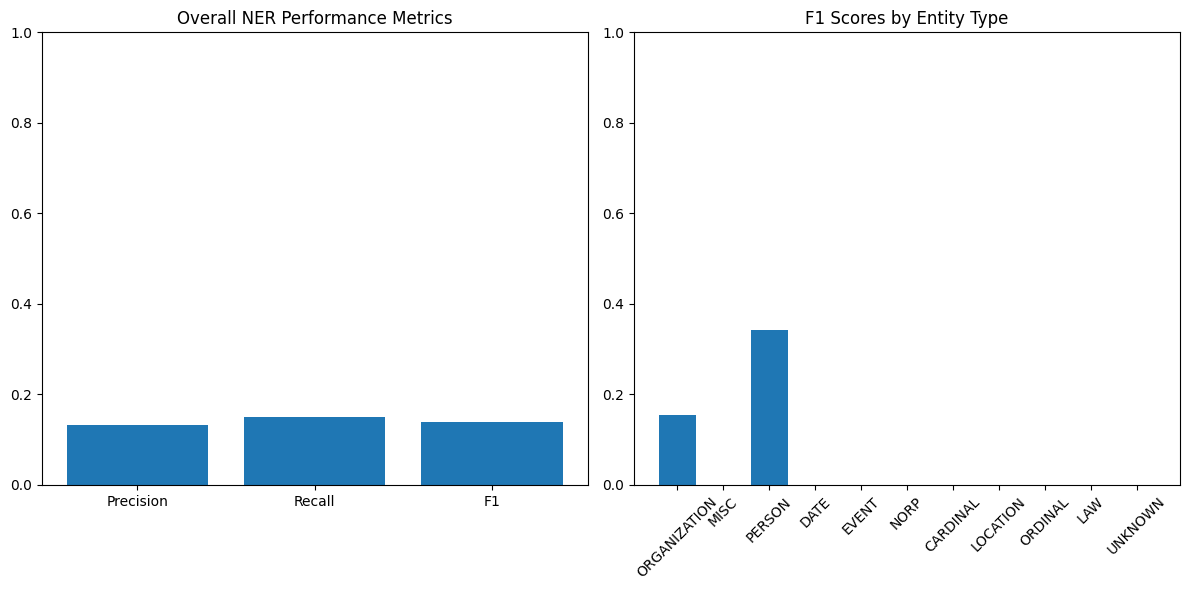

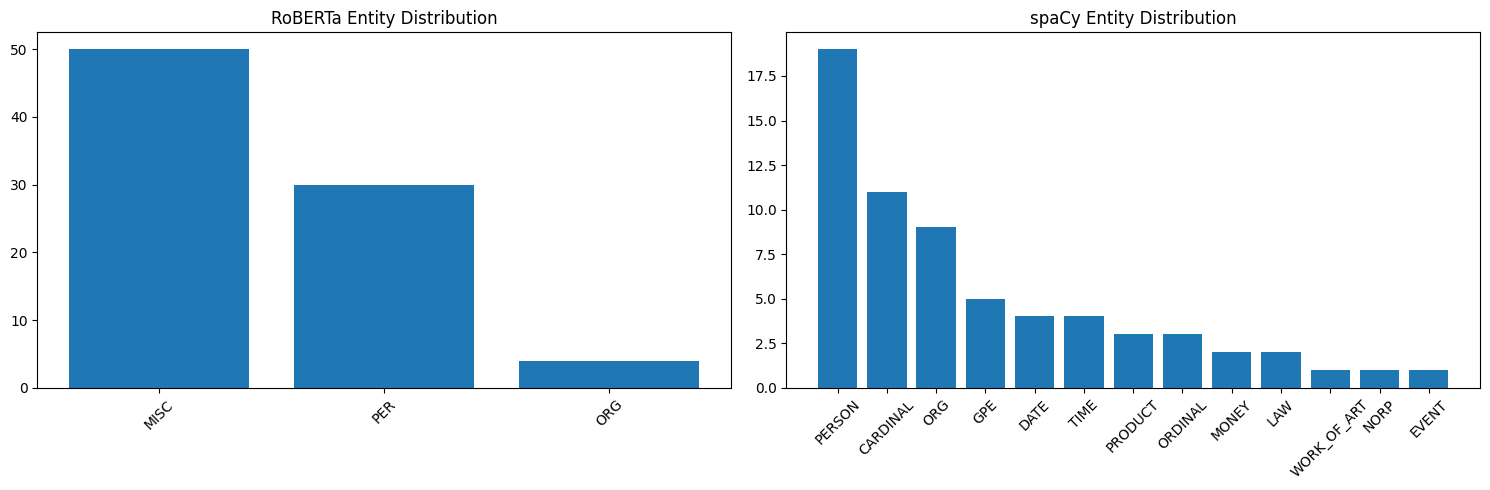

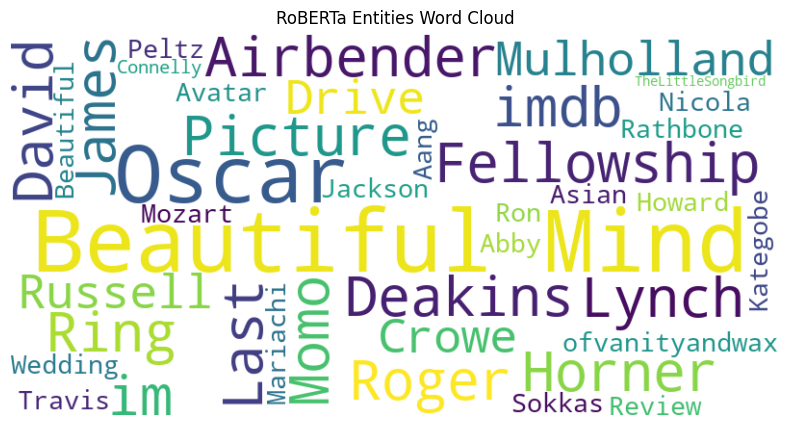

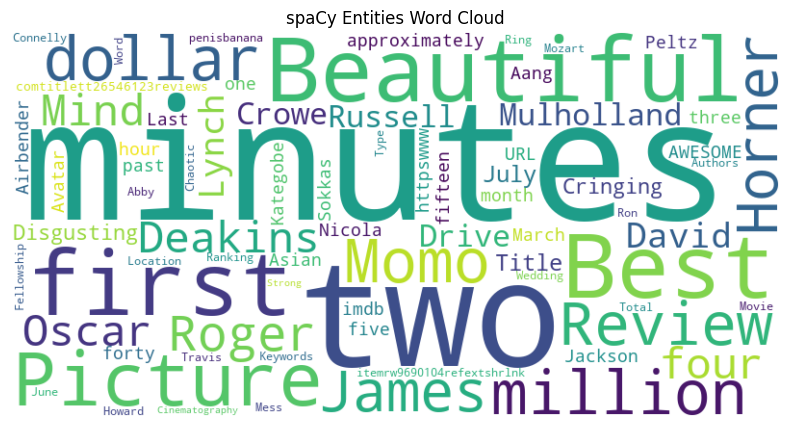


Entity Counts:

RoBERTa Entity Distribution:
MISC    50
PER     30
ORG      4
Name: count, dtype: int64

spaCy Entity Distribution:
PERSON         19
CARDINAL       11
ORG             9
GPE             5
DATE            4
TIME            4
PRODUCT         3
ORDINAL         3
MONEY           2
LAW             2
WORK_OF_ART     1
NORP            1
EVENT           1
Name: count, dtype: int64

Analysis complete!

Quick Analysis Summary:
Total RoBERTa entities found: 87
Total spaCy entities found: 65
Overall F1 Score: 0.14


In [190]:
# Import necessary libraries
import os
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")

# Define BERT Analyzer for entity extraction with chunking for longer texts
class MovieReviewRoBERTaAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
        self.model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
        self.max_length = 512

    def read_docx_file(self, file_path):
        """Read and clean text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text if text else None
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text):
        """Clean text while preserving potential named entities."""
        if not isinstance(text, str):
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)
        return text.strip()

    def split_into_chunks(self, text, max_length=512):
        """Split text into chunks that RoBERTa can process."""
        if not text:
            return []
        tokens = self.tokenizer.tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for token in tokens:
            if current_length + 1 > max_length - 2:  # -2 for [CLS] and [SEP]
                if current_chunk:
                    chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = [token]
                current_length = 1
            else:
                current_chunk.append(token)
                current_length += 1

        if current_chunk:
            chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))

        return chunks

    def extract_entities_from_chunk(self, text_chunk):
        """Extract entities from a single chunk of text."""
        if not text_chunk:
            return []

        inputs = self.tokenizer(text_chunk, return_tensors="pt", truncation=True, max_length=self.max_length, padding=True)
        
        try:
            with torch.no_grad():
                outputs = self.model(**inputs)
        except Exception as e:
            print(f"Error in model inference: {str(e)}")
            return []
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["<s>", "</s>", "<pad>"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                if token.startswith("Ġ"):
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                    current_entity = [token[1:]]
                    current_label = label
                else:
                    current_entity.append(token)
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append(("".join(current_entity), current_label))
        
        return entities

    def analyze_folder(self, folder_path):
        """Analyze all reviews in a folder."""
        if not os.path.exists(folder_path):
            print(f"Folder path does not exist: {folder_path}")
            return []

        all_entities = []
        print("\nAnalyzing files in folder...")
        
        try:
            files = [f for f in os.listdir(folder_path) if f.endswith(".docx")]
            for filename in tqdm(files, desc="Processing files"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx_file(file_path)
                if not text:
                    continue
                    
                text = self.clean_text(text)
                chunks = self.split_into_chunks(text)
                
                file_entities = []
                for chunk in chunks:
                    chunk_entities = self.extract_entities_from_chunk(chunk)
                    file_entities.extend(chunk_entities)
                all_entities.extend(file_entities)
        except Exception as e:
            print(f"Error processing folder: {str(e)}")
            return []
        
        return all_entities

def extract_entities_spacy(text):
    """Extract entities using spaCy."""
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

class NEREvaluator:
    def __init__(self):
        self.valid_entity_types = {
            'PERSON': {'PER', 'I-PER', 'B-PER', 'PERSON'},
            'ORGANIZATION': {'ORG', 'I-ORG', 'B-ORG', 'ORGANIZATION'},
            'LOCATION': {'LOC', 'GPE', 'I-LOC', 'B-LOC', 'LOCATION'},
            'MISC': {'MISC', 'I-MISC', 'B-MISC', 'WORK_OF_ART', 'PRODUCT'},
            'DATE': {'DATE', 'TIME'},
            'CARDINAL': {'CARDINAL', 'MONEY', 'QUANTITY'}
        }

    def normalize_entity_type(self, entity_type: str) -> str:
        if not isinstance(entity_type, str):
            return "UNKNOWN"
        entity_type = entity_type.upper()
        for standard_type, variants in self.valid_entity_types.items():
            if entity_type in variants:
                return standard_type
        return entity_type
    
    def normalize_entity_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        return text.lower().strip()
    
    def normalize_entities(self, entities):
        if not entities:
            return set()
        normalized = set()
        for text, entity_type in entities:
            norm_text = self.normalize_entity_text(text)
            norm_type = self.normalize_entity_type(entity_type)
            if norm_text and norm_type:
                normalized.add((norm_text, norm_type))
        return normalized
    
    def evaluate(self, true_entities, predicted_entities):
        if not true_entities or not predicted_entities:
            return {
                'overall': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 0},
                'per_type': {}
            }

        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        
        if not true_set or not pred_set:
            return {
                'overall': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 0},
                'per_type': {}
            }

        correct = len(true_set.intersection(pred_set))
        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        
        type_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
        
        for pred_text, pred_type in pred_set:
            if (pred_text, pred_type) in true_set:
                type_metrics[pred_type]['tp'] += 1
            else:
                type_metrics[pred_type]['fp'] += 1
        
        for true_text, true_type in true_set:
            if (true_text, true_type) not in pred_set:
                type_metrics[true_type]['fn'] += 1
        
        type_scores = {}
        for etype, counts in type_metrics.items():
            tp = counts['tp']
            fp = counts['fp']
            fn = counts['fn']
            
            type_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            type_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            type_f1 = 2 * (type_precision * type_recall) / (type_precision + type_recall) if (type_precision + type_recall) > 0 else 0
            
            type_scores[etype] = {
                'precision': round(type_precision, 3),
                'recall': round(type_recall, 3),
                'f1': round(type_f1, 3),
                'support': tp + fn
            }
        
        return {
            'overall': {
                'precision': round(precision, 3),
                'recall': round(recall, 3),
                'f1': round(f1, 3),
                'support': len(true_set)
            },
            'per_type': type_scores
        }

class MovieKnowledgeGraphGenerator:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.relevant_entities = {'PERSON', 'ORG', 'WORK_OF_ART', 'GPE'}
        self.relationship_patterns = [
            {"PERSON": ["directed", "directed by", "directs"], "relation": "DIRECTED"},
            {"PERSON": ["acted in", "stars in", "appeared in", "plays"], "relation": "ACTED_IN"},
            {"PERSON": ["produced", "produces"], "relation": "PRODUCED"},
            {"ORG": ["distributed", "released", "distributes"], "relation": "DISTRIBUTED"},
        ]

    def extract_relations(self, text):
        if not isinstance(text, str) or not text.strip():
            return []
            
        doc = self.nlp(text)
        relations = []
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in self.relevant_entities]
        
        for i, (ent1_text, ent1_label) in enumerate(entities):
            for j, (ent2_text, ent2_label) in enumerate(entities[i+1:], i+1):
                if i < len(doc.ents) and j < len(doc.ents):
                    start = doc.ents[i].end
                    end = doc.ents[j].start
                    between_text = doc[start:end].text.lower()
                    
                    relation = self.identify_relationship(between_text, ent1_label, ent2_label)
                    if relation:
                        relations.append((ent1_text, ent2_text, relation))
                    elif abs(j - i) <= 2:
                        relations.append((ent1_text, ent2_text, "ASSOCIATED_WITH"))

        return relations

    def identify_relationship(self, text, ent1_label, ent2_label):
        for pattern in self.relationship_patterns:
            if ent1_label in pattern:
                for verb in pattern[ent1_label]:
                    if verb in text:
                        return pattern["relation"]
        return None

    def generate_knowledge_graph(self, folder_path):
        if not os.path.exists(folder_path):
            print(f"Folder path does not exist: {folder_path}")
            return nx.Graph(), plt

        all_relations = []
        
        try:
            for filename in os.listdir(folder_path):
                if filename.endswith(".docx"):
                    file_path = os.path.join(folder_path, filename)
                    try:
                        doc = Document(file_path)
                        text = ' '.join(paragraph.text for paragraph in doc.paragraphs)
                        relations = self.extract_relations(text)
                        all_relations.extend(relations)
                    except Exception as e:
                        print(f"Error processing {filename}: {str(e)}")
                        continue
        except Exception as e:
            print(f"Error processing folder: {str(e)}")
            return nx.Graph(), plt
        
        G = nx.Graph()
        
        for subj, obj, rel in all_relations:
            G.add_edge(subj, obj, label=rel)
        
        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        nx.draw(G, pos, 
                node_color='lightblue',
                node_size=2000,
                font_size=8,
                font_weight='bold',
                with_labels=True)
        
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, 
                                   edge_labels=edge_labels,
                                   font_size=6)
        
        plt.title("Dynamic Knowledge Graph of Movie Relations", fontsize=16)
        plt.tight_layout()
        return G, plt

def create_word_cloud(entities, title="Word Cloud"):
    """
    Create and display a word cloud from entity text.
    
    Args:
        entities (list): List of tuples containing entity text and labels
        title (str): Title for the word cloud visualization
    """
    if not entities:
        print("No entities provided for word cloud generation")
        return
        
    text = ' '.join([entity[0] for entity in entities if isinstance(entity, tuple) and len(entity) >= 1])
    
    if not text.strip():
        print("No valid text found for word cloud generation")
        return
        
    try:
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white',
            max_words=100,
            min_font_size=10,
            max_font_size=50,
            random_state=42,
            collocations=False
        ).generate(text)
        
        # Create figure and display word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16, pad=20)
        
        # Adjust layout and display
        plt.tight_layout(pad=0)
        plt.show()
        
        # Save the word cloud (optional)
        try:
            filename = f"{title.lower().replace(' ', '_')}.png"
            wordcloud.to_file(filename)
            print(f"Word cloud saved as {filename}")
        except Exception as e:
            print(f"Could not save word cloud: {str(e)}")
            
    except Exception as e:
        print(f"Error generating word cloud: {str(e)}")
        return

    finally:
        plt.close()  # Clean up the figure
# [Previous code remains the same until the main function]

def main(folder_path):
    try:
        print("\nInitializing Movie Review Analysis System...")
        
        # Initialize analyzers
        bert_analyzer = MovieReviewRoBERTaAnalyzer()
        evaluator = NEREvaluator()
        
        # Process documents and extract entities
        print("\nExtracting entities using RoBERTa and spaCy...")
        all_bert_entities = []
        all_spacy_entities = []
        
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Folder not found: {folder_path}")
            
        files = [f for f in os.listdir(folder_path) if f.endswith(".docx")]
        if not files:
            raise ValueError(f"No .docx files found in {folder_path}")
        
        for filename in tqdm(files, desc="Processing files"):
            file_path = os.path.join(folder_path, filename)
            text = bert_analyzer.read_docx_file(file_path)
            
            if text.strip():
                # Get BERT entities
                text = bert_analyzer.clean_text(text)
                chunks = bert_analyzer.split_into_chunks(text)
                for chunk in chunks:
                    chunk_entities = bert_analyzer.extract_entities_from_chunk(chunk)
                    all_bert_entities.extend(chunk_entities)
                
                # Get spaCy entities
                spacy_entities = extract_entities_spacy(text)
                all_spacy_entities.extend(spacy_entities)
        
        if not all_bert_entities or not all_spacy_entities:
            print("Warning: No entities found in the documents")
            return None
        
        # Evaluate entity extraction and print detailed results
        print("\nEvaluating entity extraction performance...")
        results = evaluator.evaluate(all_bert_entities, all_spacy_entities)
        
        # Print detailed results using pandas DataFrames
        print("\nNER Evaluation Results:")
        print("\nOverall Metrics:")
        overall_df = pd.DataFrame([results['overall']])
        print(overall_df)
        print("\nOverall Metrics Description:")
        print("- Precision: Percentage of correctly identified entities out of all predictions")
        print("- Recall: Percentage of correctly identified entities out of all actual entities")
        print("- F1: Harmonic mean of precision and recall")
        print("- Support: Total number of entities in the evaluation set")
        
        print("\nPer-Entity Type Metrics:")
        per_type_df = pd.DataFrame(results['per_type']).T
        print(per_type_df)
        print("\nEntity Type Metrics Description:")
        print("- Each row shows metrics for a specific entity type (PERSON, ORGANIZATION, etc.)")
        print("- Columns show precision, recall, F1 score, and support for each type")
        
        # Generate visualizations
        print("\nGenerating visualizations...")
        create_visualizations(results, all_bert_entities, all_spacy_entities)
        
        # Print entity counts
        print("\nEntity Counts:")
        bert_types = pd.Series([ent[1] for ent in all_bert_entities]).value_counts()
        spacy_types = pd.Series([ent[1] for ent in all_spacy_entities]).value_counts()
        
        print("\nRoBERTa Entity Distribution:")
        print(bert_types)
        print("\nspaCy Entity Distribution:")
        print(spacy_types)
        
        print("\nAnalysis complete!")
        return {
            'bert_entities': all_bert_entities,
            'spacy_entities': all_spacy_entities,
            'evaluation_results': results,
            'entity_counts': {
                'roberta': bert_types.to_dict(),
                'spacy': spacy_types.to_dict()
            }
        }
        
    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        return None

# [Previous code remains the same until if __name__ == "__main__":]

if __name__ == "__main__":
    # Specify your folder path directly as a string
    folder_path = r"C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review"  
    print(f"Processing files from: {folder_path}")
    
    try:
        # Verify folder path exists
        if not os.path.exists(folder_path):
            print(f"Error: Folder not found at {folder_path}")
            exit(1)
            
        # Run the analysis
        results = main(folder_path)
        
        if results:
            print("\nQuick Analysis Summary:")
            print(f"Total RoBERTa entities found: {len(results['bert_entities'])}")
            print(f"Total spaCy entities found: {len(results['spacy_entities'])}")
            print(f"Overall F1 Score: {results['evaluation_results']['overall']['f1']}")
            
            # Create output directory for CSV files
            output_dir = os.path.join(folder_path, "analysis_results")
            os.makedirs(output_dir, exist_ok=True)
                       
        else:
            print("Analysis failed or no results were generated.")
            
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        print("Please check the folder path and ensure it contains .docx files.")

### Performance Evaluation with RoBERTa and spacy

In [245]:
# Import necessary libraries
import os
import spacy
import re
import pandas as pd
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import numpy as np
from docx import Document
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import transformers
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm

# Suppress unwanted warnings
transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load pre-trained spaCy model for entity extraction
nlp = spacy.load("en_core_web_sm")

# RoBERTa-based entity extraction analyzer class
class MovieReviewRoBERTaAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
        self.model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
        self.max_length = 512  # RoBERTa's maximum sequence length
        self.entity_labels = []  # Store entity labels

    def read_docx_file(self, file_path):
        """Read and clean text from a .docx file."""
        try:
            doc = Document(file_path)
            text = '\n'.join(paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip())
            return text if text else None
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
            return None

    def clean_text(self, text):
        """Clean text while preserving potential named entities."""
        if text is None:
            return ""
        text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces and newlines
        text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)  # Remove special characters
        return text.strip()

    def split_into_chunks(self, text, max_length=512):
        """Split text into chunks that RoBERTa can process."""
        if not text:
            return []
        tokens = self.tokenizer.tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for token in tokens:
            if current_length + 1 > max_length - 2:  # -2 for [CLS] and [SEP]
                if current_chunk:
                    chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = [token]
                current_length = 1
            else:
                current_chunk.append(token)
                current_length += 1

        if current_chunk:
            chunks.append(self.tokenizer.convert_tokens_to_string(current_chunk))

        return chunks

    def extract_entities_from_chunk(self, text_chunk):
        """Extract entities from a single chunk of text."""
        if not text_chunk:
            return []

        inputs = self.tokenizer(text_chunk, return_tensors="pt", truncation=True, max_length=self.max_length, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=2)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        entities = []
        current_entity = []
        current_label = None
        
        for token, prediction in zip(tokens, predictions[0]):
            if token in ["<s>", "</s>", "<pad>"]:
                continue
            label = self.model.config.id2label[prediction.item()]
            
            if label != "O":
                if token.startswith("Ġ"):  # RoBERTa indicates new words with "Ġ"
                    if current_entity:
                        entities.append(("".join(current_entity), current_label))
                        self.entity_labels.append(current_label)  # Store the label
                    current_entity = [token[1:]]  # Remove "Ġ" prefix
                    current_label = label
                else:
                    current_entity.append(token)
            else:
                if current_entity:
                    entities.append(("".join(current_entity), current_label))
                    self.entity_labels.append(current_label)  # Store the label
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append(("".join(current_entity), current_label))
            self.entity_labels.append(current_label)  # Store the label
        
        return entities

    def analyze_folder(self, folder_path):
        """Analyze all reviews in a folder."""
        all_entities = []
        print("\nAnalyzing files in folder...")
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(".docx"):
                file_path = os.path.join(folder_path, filename)
                text = self.read_docx_file(file_path)
                if not text:
                    print(f"Skipping empty or unreadable file: {filename}")
                    continue
                text = self.clean_text(text)
                
                # Split text into manageable chunks
                chunks = self.split_into_chunks(text)
                
                # Process each chunk
                file_entities = []
                for chunk in chunks:
                    chunk_entities = self.extract_entities_from_chunk(chunk)
                    file_entities.extend(chunk_entities)
                all_entities.extend(file_entities)
        
        return all_entities

# Entity and Relation Extraction with spaCy
def extract_entities_spacy(text):
    """Extract entities and relationships using spaCy."""
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relations = extract_relations_spacy(doc)
    return entities, relations

def extract_relations_spacy(doc):
    """Extract relations between entities using spaCy."""
    relations = []
    for ent1 in doc.ents:
        for ent2 in doc.ents:
            if ent1 != ent2 and ent1.end < ent2.start:
                between_text = doc[ent1.end:ent2.start].text
                if between_text.strip():
                    relations.append((ent1.text, ent2.text, between_text.strip()))
    return relations

# Entity and Relation Extraction with LLM + spaCy
class LLMSpacyEntityRelationExtractor:
    def __init__(self):
        self.model = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", grouped_entities=True)

    def extract_entities(self, text):
        """Use LLM to extract entities."""
        entities = self.model(text)
        formatted_entities = [(entity['word'], entity['entity_group']) for entity in entities]
        return formatted_entities

    def extract_relations(self, text):
        """Combine LLM with spaCy for relation extraction."""
        doc = nlp(text)
        relations = extract_relations_spacy(doc)
        return relations

# Evaluation
class NEREvaluator:
    def normalize_entities(self, entities):
        """Normalize entities for consistent comparison."""
        return set((text.lower().strip(), label) for text, label in entities if text and label)

    def evaluate_entities(self, true_entities, predicted_entities):
        """Evaluate entity extraction performance with rounded output."""
        true_set = self.normalize_entities(true_entities)
        pred_set = self.normalize_entities(predicted_entities)
        correct = len(true_set.intersection(pred_set))
        precision = round(correct / len(pred_set), 3) if pred_set else 0.0
        recall = round(correct / len(true_set), 3) if true_set else 0.0
        f1 = round(2 * (precision * recall) / (precision + recall), 3) if (precision + recall) > 0 else 0.0
        return {"precision": precision, "recall": recall, "f1": f1}

    def evaluate_relations(self, true_relations, predicted_relations):
        """Evaluate relation extraction performance with rounded output."""
        true_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in true_relations)
        pred_set = set((subj.lower().strip(), obj.lower().strip(), rel.lower().strip()) for subj, obj, rel in predicted_relations)
        correct = len(true_set.intersection(pred_set))
        precision = round(correct / len(pred_set), 3) if pred_set else 0.0
        recall = round(correct / len(true_set), 3) if true_set else 0.0
        f1 = round(2 * (precision * recall) / (precision + recall), 3) if (precision + recall) > 0 else 0.0
        return {"precision": precision, "recall": recall, "f1": f1}

def main(folder_path):
    """Main function for performing entity and relation extraction."""
    roberta_analyzer = MovieReviewRoBERTaAnalyzer()
    llm_spacy_extractor = LLMSpacyEntityRelationExtractor()
    evaluator = NEREvaluator()

    # Analyze folder with RoBERTa
    print("Processing documents with RoBERTa-based entity extraction...")
    roberta_entities = roberta_analyzer.analyze_folder(folder_path)
    
    # Analyze folder with spaCy
    spacy_entities, spacy_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = roberta_analyzer.read_docx_file(file_path)
            entities, relations = extract_entities_spacy(text)
            spacy_entities.extend(entities)
            spacy_relations.extend(relations)

    # Analyze folder with LLM + spaCy
    llm_entities, llm_relations = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = roberta_analyzer.read_docx_file(file_path)
            entities = llm_spacy_extractor.extract_entities(text)
            relations = llm_spacy_extractor.extract_relations(text)
            llm_entities.extend(entities)
            llm_relations.extend(relations)

    # Evaluate entity extraction
    entity_results_spacy = evaluator.evaluate_entities(roberta_entities, spacy_entities)
    entity_results_llm = evaluator.evaluate_entities(roberta_entities, llm_entities)
    print("\nEntity Extraction Evaluation:")
    print("spaCy:", entity_results_spacy)
    print("LLM + spaCy:", entity_results_llm)

    # Evaluate relation extraction
    relation_results_spacy = evaluator.evaluate_relations(spacy_relations, llm_relations)
    relation_results_llm = evaluator.evaluate_relations(spacy_relations, llm_relations)
    print("\nRelation Extraction Evaluation:")
    print("spaCy:", relation_results_spacy)
    print("LLM + spaCy:", relation_results_llm)

if __name__ == "__main__":
    folder_path = r"C:\Users\Raspatel\Downloads\NLP Assignment 3\Movie Review"
    main(folder_path)


Processing documents with RoBERTa-based entity extraction...

Analyzing files in folder...


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Entity Extraction Evaluation:
spaCy: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
LLM + spaCy: {'precision': 0.444, 'recall': 0.267, 'f1': 0.333}

Relation Extraction Evaluation:
spaCy: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
LLM + spaCy: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


#### Insights
Comparing BERT both models and RoBERTa the Relation extraction gives same results.For Entity extraction Evaluation with spaCy gives 0 values for all three models used in LLM.But for LLM+spaCy the results differ slightly showing the pretrained model capacity and its characteristics.bert-large typically achieves slightly better accuracy,bert-base offers better performance/resource trade-off.Similarly dslim/bert-base is faster in inference
dbmdz/bert-large takes longer but might be more accurate.

Overall as per results BERT large is faster then RoBERTa  and lastly BERT base in handling Entity and Relation Extraction.
